In [131]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
import datetime as dt
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import os
from shutil import copy
import seaborn as sns
import scipy.stats as stats
import datetime
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import imageio
from itertools import compress

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
#‘xx-small’, ‘x-small’, ‘small’, ‘medium’, ‘large’, ‘x-large’, ‘xx-large’
pylab.rcParams.update(params)
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from statsmodels.tsa.api import VAR

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn import tree

import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [303]:
#read data
#delta - 14 days SW-14 days FW
#median tempr - median temperature since first feeding until shipout
df=pd.read_csv('data\\smolt_temp_dataset.csv',sep=';')
df.transfer_date = pd.to_datetime(df.transfer_date,format='%d.%m.%Y')
print("Min Date:", df.transfer_date.min().strftime("%Y-%m-%d"),
      "\nMax Date:", df.transfer_date.max().strftime("%Y-%m-%d"))
for c in ['delta','median_tempr','average_tempr','Proxy']:
    df[c]=(df[c].str.replace(',', '.')).astype('float')
df['delta_FW_minus_SW']=-df['delta']
season_dic2 = {1: 'Dec-Feb',2: 'Mar-May',3: 'Jun-Aug',4: 'Sep-Nov'}
df['transfer_season2']=(df['transfer_date'].dt.month%12 // 3 + 1).apply(lambda x: season_dic2[x])
reverse_season_dic = {v: k for k, v in season_dic2.items()}

# #tmp
# df=df[df['delta_FW_minus_SW']<6]

step=0.5
bins_tuple=tuple(i*step for i in range(int(df['median_tempr'].min()/step), int(df['median_tempr'].max()/step)+1))
df['median_tempr_cat0.5'] = pd.cut(df['median_tempr'], bins=bins_tuple)
bins_tuple=tuple(i*step for i in range(int(df['delta_FW_minus_SW'].min()/step), int(df['delta_FW_minus_SW'].max()/step)+1))
df['delta_FW_minus_SW_cat0.5'] = pd.cut(df['delta_FW_minus_SW'], bins=bins_tuple)

step=0.25
bins_tuple=tuple(i*step for i in range(int(df['median_tempr'].min()/step), int(df['median_tempr'].max()/step)+1))
df['median_tempr_cat0.25'] = pd.cut(df['median_tempr'], bins=bins_tuple)
bins_tuple=tuple(i*step for i in range(int(df['delta_FW_minus_SW'].min()/step), int(df['delta_FW_minus_SW'].max()/step)+1))
df['delta_FW_minus_SW_cat0.25'] = pd.cut(df['delta_FW_minus_SW'], bins=bins_tuple)
df['degree_days']=df['sum_of_temp']

#adding mortality column
df_tmp=pd.read_csv('data\\smolt_data.csv',sep=';')
df=df.merge(df_tmp[['to_locus_id','to_fish_group_id','total_mortality_perc_90','locus_id', 'fish_group_id', 'transfer_year']],how='left')

#adding sw growth 90 days
df_transfers_sw_growth=pd.read_csv('data\\transfers_with_sw_growth_and_feed_first_90days.csv')
df=df.merge(df_transfers_sw_growth[['locus_id','fish_group_id','growth_90days','stocking_weight']],how='left')
df['SGR_SW'] = 100*(df['growth_90days']**(1/90) - 1)
df['biomass_90days_1000fish_kg']=df['to_avg_weight']*df['growth_90days']*(1-df['total_mortality_perc_90'])*1000/1000


#adding SW temperature for TGC
df_sw_temp=pd.read_csv('data\\seawater_temperature__for_transfers_since_2017_only_first_90days_after_transfer_with_fish_group_id.csv')
df_sw_temp_grouped=df_sw_temp.groupby(['locus_id','to_fish_group_id']).temperature.sum().reset_index().rename(columns={'temperature':'degree_days_first_90days_after_transfer'})
df=df.merge(df_sw_temp_grouped, on=['locus_id','to_fish_group_id'],how='left')
df=df[df.degree_days_first_90days_after_transfer>=800]
df['avg_weight_90days'] = df['to_avg_weight']*df['growth_90days']
df['TGC_SW'] = 1000* ((df['avg_weight_90days']**(1/3)-df['to_avg_weight']**(1/3)) / df['degree_days_first_90days_after_transfer'])
df['average_temperature_first_90days_after_transfer']=df['degree_days_first_90days_after_transfer']/90

Min Date: 2018-04-09 
Max Date: 2022-09-22


In [304]:
df

,from_locus_population_id,from_fish_group_id,from_fish_group_name,from_generation,from_year_class,from_count_stocking,from_avg_weight,to_date,type_id,to_site_name,...,fish_group_id,transfer_year,growth_90days,stocking_weight,SGR_SW,biomass_90days_1000fish_kg,degree_days_first_90days_after_transfer,avg_weight_90days,TGC_SW,average_temperature_first_90days_after_transfer
0,36784356,305,72G1709.SNFLY1700.C2.PH,2017,2017,40000,121,12.04.2018,2,Fiordo Largo,...,28,2018,3.782996,121.0,1.489333,453.189555,1029.530,457.742462,2.681521,11.439222
1,36783456,305,72G1709.SNFLY1700.C2.PH,2017,2017,40000,121,10.04.2018,2,Fiordo Largo,...,28,2018,4.221535,121.0,1.613093,506.909863,1033.730,510.805695,2.948243,11.485889
2,36783456,305,72G1709.SNFLY1700.C2.PH,2017,2017,25070,121,10.04.2018,2,Fiordo Largo,...,28,2018,3.416463,129.5,1.374478,410.118167,1107.710,413.392040,2.259890,12.307889
3,36783456,305,72G1709.SNFLY1700.C2.PH,2017,2017,32107,121,10.04.2018,2,Fiordo Largo,...,28,2018,4.184999,121.0,1.603280,500.202020,1033.730,506.384918,2.925870,11.485889
4,36783641,305,72G1709.SNFLY1700.C2.PH,2017,2017,40000,117,12.04.2018,2,Fiordo Largo,...,28,2018,4.245437,117.0,1.619468,492.514737,1029.530,496.716156,2.941748,11.439222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,194521121,6043,72G2202.SNLCY2100.C3B.PH,2022,2021,8606,160,21.09.2022,2,Loncochalgua,...,6109,2022,5.635953,159.4,1.939872,897.826840,1193.275,901.752487,3.546811,13.258611
760,194521282,6043,72G2202.SNLCY2100.C3B.PH,2022,2021,8673,160,22.09.2022,2,Loncochalgua,...,6109,2022,5.850963,158.0,1.982287,930.982559,1194.955,936.154144,3.643357,13.277278
761,194521298,6043,72G2202.SNLCY2100.C3B.PH,2022,2021,9906,151,22.09.2022,2,Loncochalgua,...,6109,2022,5.981240,151.2,2.007244,898.671278,1194.955,903.167304,3.632884,13.277278
762,194521595,6043,72G2202.SNLCY2100.C3B.PH,2022,2021,8626,153,23.09.2022,2,Loncochalgua,...,6109,2022,5.724568,153.0,1.957544,870.624714,1188.575,875.858931,3.549884,13.206389


In [305]:
df_transfers_sw_growth

,site_id,locus_id,fish_group_id,transfer_date,stocking_weight,stocking_count,event_date,close_count_90,close_weight_90,growth_90days,sum_feed_90_kg
0,8526,3051003,6179,2023-02-28,255.000000,45650,2023-05-29,45406,803.645914,3.151553,23190.0
1,8526,3046444,6179,2023-02-26,263.000000,45650,2023-05-27,45409,786.006296,2.988617,22125.0
2,8526,3048402,6179,2023-02-26,260.333333,45650,2023-05-27,45351,830.755761,3.191123,24087.0
3,8526,3048544,6179,2023-02-26,256.700000,45650,2023-05-27,45254,856.549182,3.336771,25392.0
4,8526,3047361,6179,2023-02-24,257.777778,45650,2023-05-25,45459,844.738133,3.277001,24828.0
...,...,...,...,...,...,...,...,...,...,...,...
1300,8552,3048739,568,2017-01-04,91.000000,45067,2017-04-04,44470,420.056915,4.616010,13843.0
1301,8552,3049259,568,2017-01-04,100.500000,45103,2017-04-04,44717,442.440948,4.402397,14831.0
1302,8552,3046036,11,2017-01-03,113.000000,45121,2017-04-03,44784,506.380585,4.481244,16814.5
1303,8552,3047664,11,2017-01-03,113.000000,45063,2017-04-03,44717,487.911835,4.317804,15904.5


# Stocking TGC_SW

In [306]:
correlation = df['stocking_weight'].corr(df['total_mortality_perc_90'])

print("Correlation between stocking_weight and total_mortality_perc_90:", correlation)

Correlation between stocking_weight and total_mortality_perc_90: 0.10631749771663707


In [307]:
df = df.dropna(subset=['stocking_weight'])
df = df.dropna(subset=['total_mortality_perc_90'])

df = df.reset_index(drop=True)

In [308]:
len(df)

751

In [309]:
median_stocking_weight = df['stocking_weight'].median()


df['group'] = np.where(df['stocking_weight'] < median_stocking_weight, 0, 1)

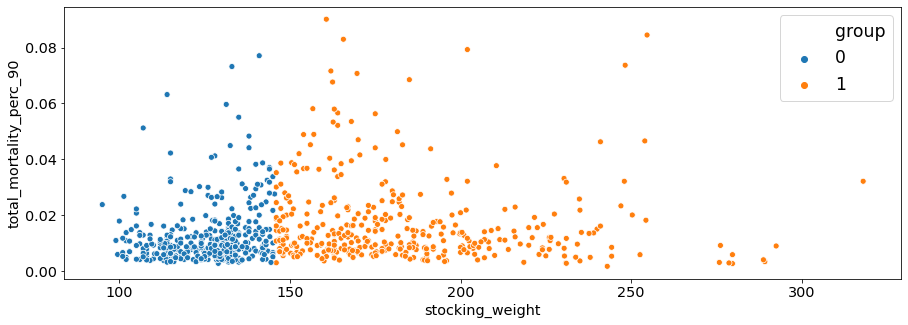

In [310]:
sns.scatterplot(data=df, x='stocking_weight', y='total_mortality_perc_90', hue='group')
plt.show()


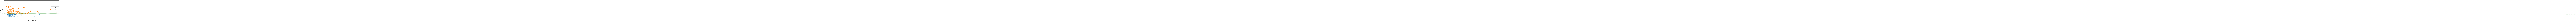

In [312]:

scatter_plot =sns.scatterplot(data=df, y='stocking_weight', x='total_mortality_perc_90', hue='group')
scatter_plot.axhline(median_stocking_weight, linestyle='--', color='green')
scatter_plot.text(df['TGC_SW'].max(), median_stocking_weight, f"median={median_stocking_weight:.2f}", color='green',fontsize=18, ha='right', va='top')
plt.show()


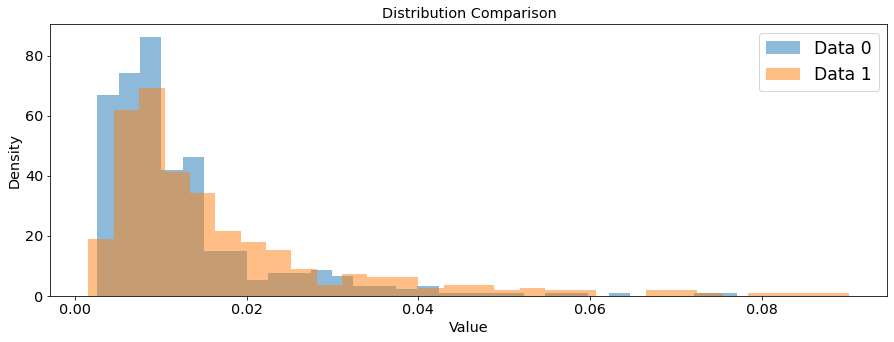

In [313]:
data0 = df[df['group'] == 0]['total_mortality_perc_90']
data1 = df[df['group'] == 1]['total_mortality_perc_90']
plt.hist(data0, bins=30, alpha=0.5, label='Data 0', density=True)
plt.hist(data1, bins=30, alpha=0.5, label='Data 1', density=True)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

In [263]:

mean_values = df.groupby('group')['TGC_SW'].mean()
median_values = df.groupby('group')['TGC_SW'].median()
min_values = df.groupby('group')['TGC_SW'].min()
max_values = df.groupby('group')['TGC_SW'].max()

print("Mean values:")
print(mean_values)
print("\nMedian values:")
print(median_values)
#print("\nMode values:")
#print(mode_values)
print("\nMinimum values:")
print(min_values)
print("\nMaximum values:")
print(max_values)

Mean values:
group
0    0.012594
1    0.016868
Name: total_mortality_perc_90, dtype: float64

Median values:
group
0    0.009145
1    0.011749
Name: total_mortality_perc_90, dtype: float64

Minimum values:
group
0    0.002648
1    0.001601
Name: total_mortality_perc_90, dtype: float64

Maximum values:
group
0    0.077095
1    0.090181
Name: total_mortality_perc_90, dtype: float64


In [264]:
data1 = df[df['group'] == 1]['TGC_SW']
data0 = df[df['group'] == 0]['TGC_SW']

In [265]:
num_samples=5000
sample_size=20
p_values=[]
u_stats=[]
for i in range(num_samples):
    sample0 = np.random.choice(data0, size=sample_size, replace=True)
    sample1 = np.random.choice(data1, size=sample_size, replace=True)
    statistic, p_value = mannwhitneyu(sample0, sample1, alternative='greater')
    p_values.append(p_value)
    u_stats.append(statistic)
    #print("Mann-Whitney U statistic: ", statistic)
    #print("P-Value: ", p_value)

(array([3.50877193e-05, 3.43859649e-04, 2.40701754e-03, 6.79298246e-03,
        1.03789474e-02, 9.03859649e-03, 4.49824561e-03, 1.26315789e-03,
        2.87719298e-04, 4.21052632e-05]),
 array([ 24. ,  52.5,  81. , 109.5, 138. , 166.5, 195. , 223.5, 252. ,
        280.5, 309. ]),
 <a list of 10 Patch objects>)

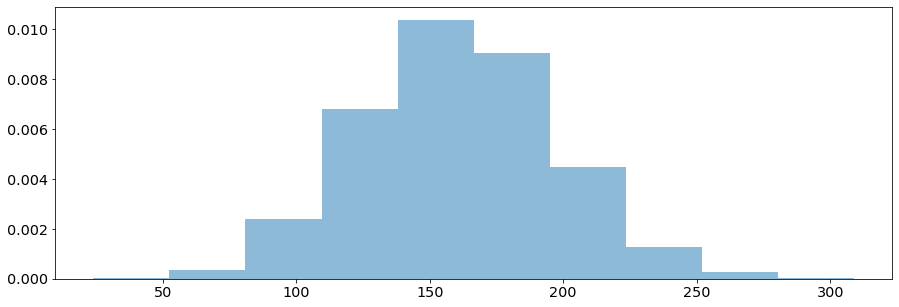

In [266]:
plt.hist(u_stats, alpha=0.5, density=True)

In [267]:
passed_count=0
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        passed_count=passed_count+1
print("Number of tests passed=",passed_count,"/",num_samples,"tests runned")

Number of tests passed= 0 / 5000 tests runned


In [268]:

group_0 = df[df['group'] == 0]['TGC_SW']
group_1 = df[df['group'] == 1]['TGC_SW']

# Run t-test
t_statistic, p_value = stats.ttest_ind(group_0, group_1)

# Print the t-statistic and p-value
print("T-Statistic: ", t_statistic)
print("P-Value: ", p_value)

T-Statistic:  -4.53692691083714
P-Value:  6.6463145889138115e-06


In [269]:
group_0_dispersion = np.var(group_0)
group_1_dispersion = np.var(group_1)

print("Dispersion for group 0:", group_0_dispersion)
print("Dispersion for group 1:", group_1_dispersion)

Dispersion for group 0: 0.00011246055542304672
Dispersion for group 1: 0.0002194597562754295


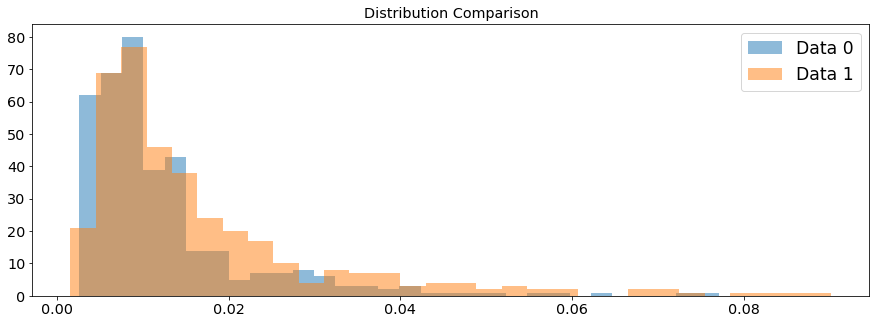

In [270]:
plt.hist(data0, bins=30, alpha=0.5, label='Data 0', density=False)
plt.hist(data1, bins=30, alpha=0.5, label='Data 1', density=False)


plt.title('Distribution Comparison')
plt.legend()

plt.show()

In [271]:
data1_copy=data1.copy()

In [272]:
data1_copy.sort_values(inplace=True)

In [273]:
data1_copy

679    0.001601
692    0.002577
683    0.002683
681    0.002803
694    0.002815
         ...   
421    0.073691
254    0.079301
431    0.082999
422    0.084519
261    0.090181
Name: total_mortality_perc_90, Length: 377, dtype: float64

In [239]:
dispersion=data1_copy.var()
while dispersion>=0.119:
    data1_copy = data1_copy.iloc[1:-1]
    dispersion = data1_copy.var()
    median_d1= data1_copy.median()
    print(dispersion, median_d1)
    

0.27356547439033196 2.8970647203565876
0.25686128956240317 2.8970647203565876
0.2466374985394706 2.8970647203565876
0.23758207834096742 2.8970647203565876
0.23011476615725732 2.8970647203565876
0.22379796158567128 2.8970647203565876
0.21950769205851872 2.8970647203565876
0.21532138431203834 2.8970647203565876
0.21111518776492516 2.8970647203565876
0.20713300013998018 2.8970647203565876
0.2033980078624043 2.8970647203565876
0.1997054532767525 2.8970647203565876
0.19601118626606734 2.8970647203565876
0.1923618113703773 2.8970647203565876
0.18879647637075717 2.8970647203565876
0.1852966907000592 2.8970647203565876
0.18194282137095039 2.8970647203565876
0.1787898993945385 2.8970647203565876
0.17573118292997092 2.8970647203565876
0.172743198601676 2.8970647203565876
0.16992234542725804 2.8970647203565876
0.16711714057876192 2.8970647203565876
0.16435133733554372 2.8970647203565876
0.16162617723197048 2.8970647203565876
0.1589004040161908 2.8970647203565876
0.1562146020298521 2.8970647203565

In [274]:
data1_copy

679    0.001601
692    0.002577
683    0.002683
681    0.002803
694    0.002815
         ...   
421    0.073691
254    0.079301
431    0.082999
422    0.084519
261    0.090181
Name: total_mortality_perc_90, Length: 377, dtype: float64

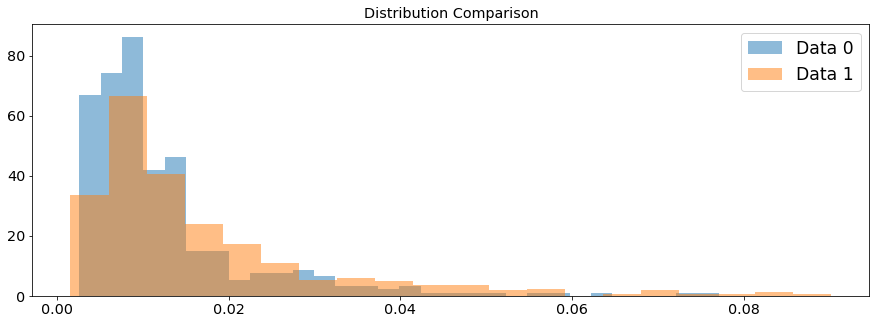

In [275]:
plt.hist(data0, bins=30, alpha=0.5, label='Data 0', density=True)
plt.hist(data1_copy, bins=20, alpha=0.5, label='Data 1', density=True)


plt.title('Distribution Comparison')
plt.legend()

plt.show()

In [276]:
group_0 = data0
group_1 = data1_copy

# Run t-test
t_statistic, p_value = stats.ttest_ind(group_0, group_1)

# Print the t-statistic and p-value
print("T-Statistic: ", t_statistic)
print("P-Value: ", p_value)
group_0_dispersion = np.var(group_0)
group_1_dispersion = np.var(group_1)

print("Dispersion for group 0:", group_0_dispersion)
print("Dispersion for group 1:", group_1_dispersion)
print (len(group_0))
print (len(group_1))

T-Statistic:  -4.53692691083714
P-Value:  6.6463145889138115e-06
Dispersion for group 0: 0.00011246055542304672
Dispersion for group 1: 0.00021945975627542954
374
377


In [277]:
num_samples=5000
sample_size=20
p_values=[]
u_stats=[]
for i in range(num_samples):
    sample0 = np.random.choice(group_0, size=sample_size, replace=True)
    sample1 = np.random.choice(group_1, size=sample_size, replace=True)
    statistic, p_value = mannwhitneyu(sample0, sample1, alternative='less')
    p_values.append(p_value)
    u_stats.append(statistic)
    #print("Mann-Whitney U statistic: ", statistic)
    #print("P-Value: ", p_value)

(array([1.41666667e-04, 8.50000000e-04, 3.30833333e-03, 7.76666667e-03,
        1.05166667e-02, 9.71666667e-03, 6.19166667e-03, 2.49166667e-03,
        5.91666667e-04, 9.16666667e-05]),
 array([ 44.,  68.,  92., 116., 140., 164., 188., 212., 236., 260., 284.]),
 <a list of 10 Patch objects>)

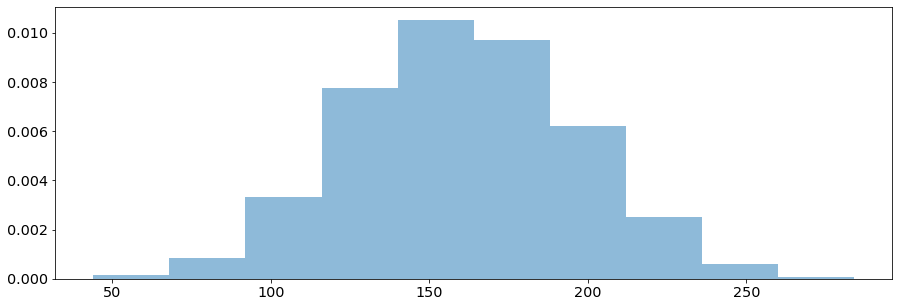

In [278]:
plt.hist(u_stats, alpha=0.5, density=True)

In [279]:
passed_count=0
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        passed_count=passed_count+1
print("Number of tests passed=",passed_count,"/",num_samples,"tests runned")

Number of tests passed= 1400 / 5000 tests runned


In [280]:
u_stats_failed=[]
u_stats_passed=[]
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        u_stats_passed.append(u_stats[i])
    else:
        u_stats_failed.append(u_stats[i])

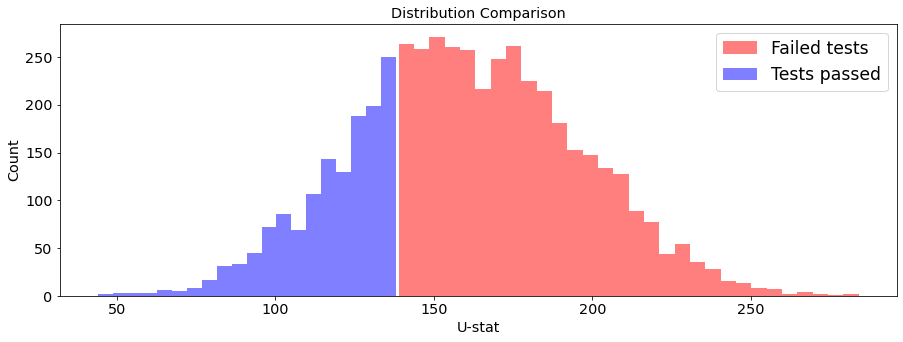

In [281]:
plt.hist(u_stats_failed, alpha=0.5, bins=30, label='Failed tests', density=False, color='red')
plt.hist(u_stats_passed, alpha=0.5, bins=20, label='Tests passed', density=False, color='blue')

plt.xlabel('U-stat')
plt.ylabel('Count')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

# Stocking mortality

In [246]:
correlation = df['stocking_weight'].corr(df['TGC_SW'])

print("Correlation between stocking_weight and TGC_SW:", correlation)

Correlation between stocking_weight and TGC_SW: -0.2987375189731083


In [247]:
df = df.dropna(subset=['stocking_weight'])
df = df.dropna(subset=['TGC_SW'])

df = df.reset_index(drop=True)

In [248]:
median_stocking_weight = df['stocking_weight'].median()


df['group'] = np.where(df['stocking_weight'] < median_stocking_weight, 0, 1)

# Season testing

In [3]:
df=pd.read_csv("smolt_dataset.csv", delimiter=';')

In [4]:
df

,locus_id,fish_group_id,transfer_year,transfer_month,transfer_month_year,transfer_season,total_count,total_mortality_perc_90,transport_mortality_perc_90,nontransport_mortality_perc_90,...,days_btw_transfer_conf,SGR,TGC,order_of_creation_from,strain,year_class,number_of_prod_cycle,place_first_feeding,specific_treatment,two_place_of_first_feeding
0,3046036,11,2017,1,1_2017,winter,"44934,175","0,007496165","0,001309054","0,006187111",...,NaN,NaN,NaN,6,FAN,16,C1,PH,None,0
1,3046036,1052,2019,1,1_2019,winter,"46388,23077","0,003942904","0,000924979","0,003017925",...,56.0,"0,863440282","0,951440321",5,FLY,18,C1B,PH,None,0
2,3046036,3918,2020,11,11_2020,autumn,"45241,16667","0,007676062","0,005640632","0,002035429",...,49.0,"0,972984604","1,181745984",11,FLY,19,C4,PH,LUF,0
3,3046043,310,2017,6,6_2017,summer,"38451,42593","0,018393697","0,006842934","0,011550763",...,NaN,NaN,NaN,10,FLY,16,C2B,PH,None,0
4,3046043,498,2019,7,7_2019,summer,"41131,79661","0,027013536","0,022782874","0,004230661",...,93.0,"0,800972852","0,883692915",3,LCY,18,C3,PGR,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,7183889,6071,2022,6,6_2022,summer,"44747,76389","0,012812974","0,002758736","0,010054239",...,77.0,"0,692506163","0,768343162",3,FLY,21,C2,PH,LUF,0
1087,7183890,6072,2022,6,6_2022,summer,"44563,77612","0,014813398","0,008025966","0,006787432",...,66.0,"0,862384041","0,958244367",3,FLY,21,C2,PH,LUF,0
1088,7183891,6072,2022,6,6_2022,summer,"44585,79167","0,01465357","0,007419565","0,007234005",...,64.0,"0,695116331","0,801179534",3,FLY,21,C2,PH,LUF,0
1089,7183892,6069,2022,6,6_2022,summer,"44244,95833","0,022575856","0,015284297","0,007291559",...,73.0,"0,79240455","0,87628003",3,FLY,21,C2,PH,LUF,0


In [32]:
filtered_df = pd.DataFrame(columns=['transfer_season', 'total_mortality_perc_90', 'group'])

# Iterate over each row in the original dataframe
for index, row in df.iterrows():
    transfer_season = row['transfer_season']
    
    # Assign group based on transfer_season value
    if transfer_season in ['autumn', 'spring']:
        group = 0
    else:
        group = 1
    
    # Create a new row with the required values
    new_row = {
        'transfer_season': transfer_season,
        'total_mortality_perc_90': row['total_mortality_perc_90'],
        'group': group
    }
    
    # Append the new row to the new dataframe
    filtered_df = filtered_df.append(new_row, ignore_index=True)

filtered_df

,transfer_season,total_mortality_perc_90,group
0,winter,"0,007496165",1
1,winter,"0,003942904",1
2,autumn,"0,007676062",0
3,summer,"0,018393697",1
4,summer,"0,027013536",1
...,...,...,...
1086,summer,"0,012812974",1
1087,summer,"0,014813398",1
1088,summer,"0,01465357",1
1089,summer,"0,022575856",1


In [33]:
filtered_df['total_mortality_perc_90'] = filtered_df['total_mortality_perc_90'].str.replace(',', '.')

filtered_df['total_mortality_perc_90'] = filtered_df['total_mortality_perc_90'].astype(float)

In [35]:
filtered_df.to_csv("for_mw.csv")

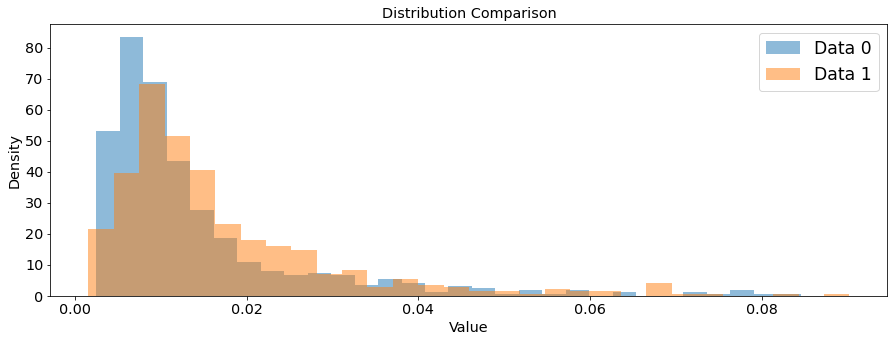

In [36]:
data0 = filtered_df[filtered_df['group'] == 0]['total_mortality_perc_90']
data1 = filtered_df[filtered_df['group'] == 1]['total_mortality_perc_90']
plt.hist(data0, bins=30, alpha=0.5, label='Data 0', density=True)
plt.hist(data1, bins=30, alpha=0.5, label='Data 1', density=True)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

In [37]:
from scipy.stats import mannwhitneyu

group_0 = filtered_df[filtered_df['group'] == 0]['total_mortality_perc_90']
group_1 = filtered_df[filtered_df['group'] == 1]['total_mortality_perc_90']

statistic, p_value = mannwhitneyu(group_0, group_1, alternative='greater')

print("Mann-Whitney U statistic: ", statistic)
print("P-Value: ", p_value)

Mann-Whitney U statistic:  117605.5
P-Value:  0.999999993483392


In [38]:
num_samples=5000
sample_size=20
p_values=[]
u_stats=[]
for i in range(num_samples):
    sample0 = np.random.choice(data0, size=sample_size, replace=True)
    sample1 = np.random.choice(data1, size=sample_size, replace=True)
    statistic, p_value = mannwhitneyu(sample0, sample1, alternative='less')
    p_values.append(p_value)
    u_stats.append(statistic)
    #print("Mann-Whitney U statistic: ", statistic)
    #print("P-Value: ", p_value)

(array([0.00011864, 0.00117797, 0.00336441, 0.00795763, 0.01051695,
        0.00978814, 0.00589831, 0.0025339 , 0.00090678, 0.00011017]),
 array([ 45. ,  68.6,  92.2, 115.8, 139.4, 163. , 186.6, 210.2, 233.8,
        257.4, 281. ]),
 <a list of 10 Patch objects>)

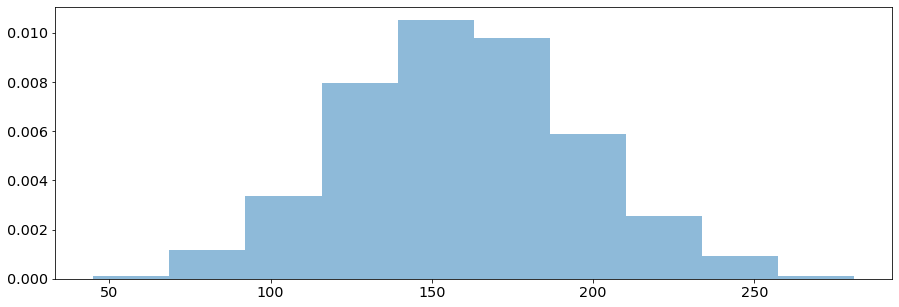

In [39]:
plt.hist(u_stats, alpha=0.5, density=True)

In [40]:
#critical value for U-stats with sample size(20,20)=138
passed_count=0
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        passed_count=passed_count+1
print("Number of tests passed=",passed_count,"/",num_samples,"tests runned")

Number of tests passed= 1438 / 5000 tests runned


In [41]:
u_stats_failed=[]
u_stats_passed=[]
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        u_stats_passed.append(u_stats[i])
    else:
        u_stats_failed.append(u_stats[i])
        
        

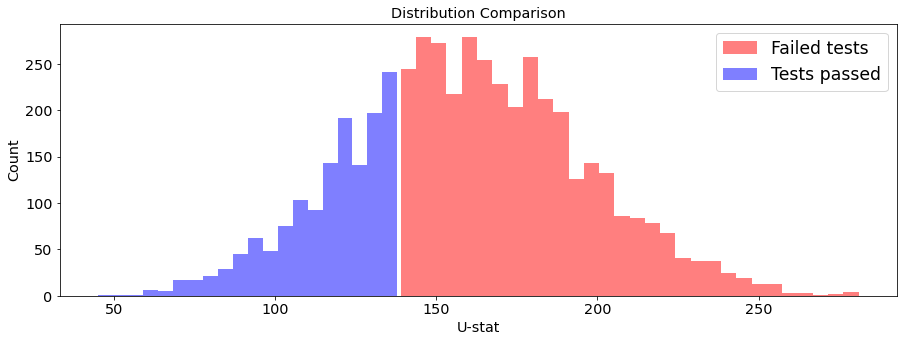

In [44]:
plt.hist(u_stats_failed, alpha=0.5, bins=30, label='Failed tests', density=False, color='red')
plt.hist(u_stats_passed, alpha=0.5, bins=20, label='Tests passed', density=False, color='blue')

plt.xlabel('U-stat')
plt.ylabel('Count')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

# Strain testing

In [112]:
df=pd.read_csv("smolt_dataset.csv", delimiter=';')

In [113]:
filtered_df = pd.DataFrame(columns=['strain', 'total_mortality_perc_90', 'group'])

# Iterate over each row in the original dataframe
for index, row in df.iterrows():
    strain = row['strain']
    
    # Assign group based on transfer_season value
    if strain in ['AQG', 'FLY','LCY']:
        group = 0
    else:
        group = 1
    
    # Create a new row with the required values
    new_row = {
        'strain': transfer_season,
        'total_mortality_perc_90': row['total_mortality_perc_90'],
        'group': group
    }
    
    # Append the new row to the new dataframe
    filtered_df = filtered_df.append(new_row, ignore_index=True)

filtered_df

,strain,total_mortality_perc_90,group
0,FLY,"0,007496165",1
1,FLY,"0,003942904",0
2,FLY,"0,007676062",0
3,FLY,"0,018393697",0
4,FLY,"0,027013536",0
...,...,...,...
1086,FLY,"0,012812974",0
1087,FLY,"0,014813398",0
1088,FLY,"0,01465357",0
1089,FLY,"0,022575856",0


In [114]:
filtered_df['total_mortality_perc_90'] = filtered_df['total_mortality_perc_90'].str.replace(',', '.')

filtered_df['total_mortality_perc_90'] = filtered_df['total_mortality_perc_90'].astype(float)

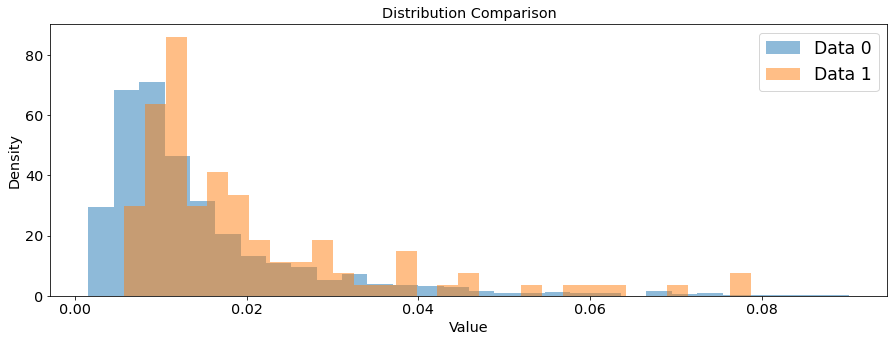

In [115]:
data0 = filtered_df[filtered_df['group'] == 0]['total_mortality_perc_90']
data1 = filtered_df[filtered_df['group'] == 1]['total_mortality_perc_90']
plt.hist(data0, bins=30, alpha=0.5, label='Data 0', density=True)
plt.hist(data1, bins=30, alpha=0.5, label='Data 1', density=True)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

In [116]:
num_samples=5000
sample_size=20
p_values=[]
u_stats=[]
for i in range(num_samples):
    sample0 = np.random.choice(data0, size=sample_size, replace=True)
    sample1 = np.random.choice(data1, size=sample_size, replace=True)
    statistic, p_value = mannwhitneyu(sample0, sample1, alternative='less')
    p_values.append(p_value)
    u_stats.append(statistic)
    #print("Mann-Whitney U statistic: ", statistic)
    #print("P-Value: ", p_value)

In [127]:
passed_count=0
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        passed_count=passed_count+1
print("Number of tests passed=",passed_count,"/",num_samples,"tests runned")

Number of tests passed= 2998 / 5000 tests runned


In [128]:
u_stats_failed=[]
u_stats_passed=[]
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.5 and u_stats[i]<=138:
        u_stats_passed.append(u_stats[i])
    else:
        u_stats_failed.append(u_stats[i])
        

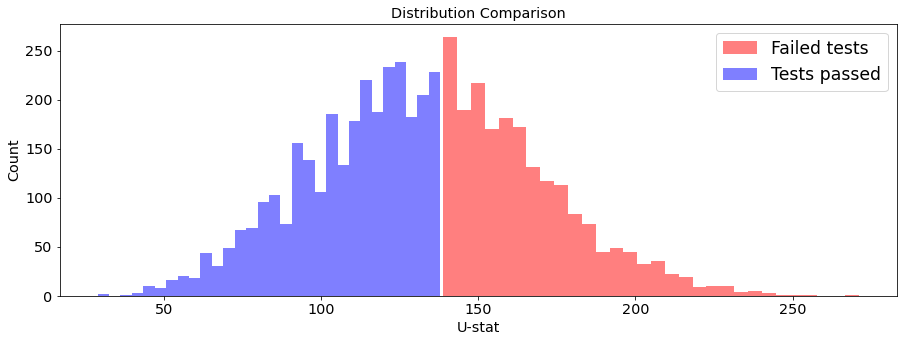

In [129]:
plt.hist(u_stats_failed, alpha=0.5, bins=30, label='Failed tests', density=False, color='red')
plt.hist(u_stats_passed, alpha=0.5, bins=30, label='Tests passed', density=False, color='blue')

plt.xlabel('U-stat')
plt.ylabel('Count')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

# Vac Weight


In [287]:
df_smolt_data=pd.read_csv("smolt_dataset.csv", delimiter=';')

In [288]:
df_smolt_data['total_mortality_perc_90'] = df_smolt_data['total_mortality_perc_90'].str.replace(',', '.')

df_smolt_data['total_mortality_perc_90'] = df_smolt_data['total_mortality_perc_90'].astype(float)

In [289]:
average_mortality = df_smolt_data.groupby('vac_weight')['total_mortality_perc_90'].mean().reset_index()

In [290]:
average_mortality

,vac_weight,total_mortality_perc_90
0,41.0,0.004701
1,45.0,0.005951
2,49.0,0.017917
3,51.0,0.009220
4,52.0,0.012259
...,...,...
70,145.0,0.009074
71,156.0,0.009088
72,157.0,0.052652
73,159.0,0.020038


In [291]:
correlation = average_mortality['vac_weight'].corr(average_mortality['total_mortality_perc_90'])

print("Correlation between vac_weight and total_mortality_perc_90:", correlation)

Correlation between vac_weight and total_mortality_perc_90: 0.29680995607510324


In [292]:
median_sgr = average_mortality['vac_weight'].median()


average_mortality['group'] = np.where(average_mortality['vac_weight'] < median_sgr, 0, 1)

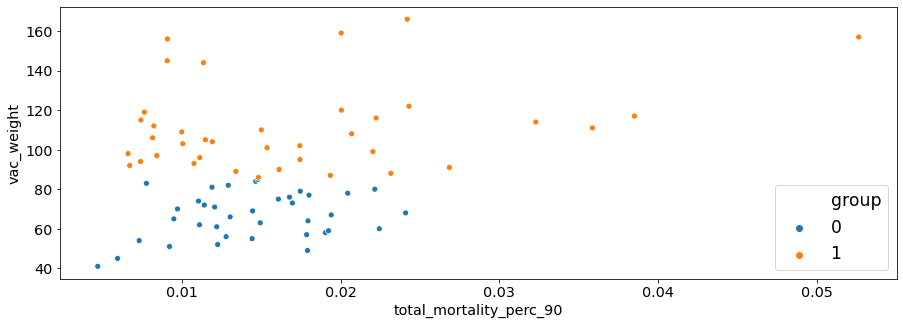

In [293]:
sns.scatterplot(data=average_mortality, y='vac_weight', x='total_mortality_perc_90', hue='group')
plt.show()


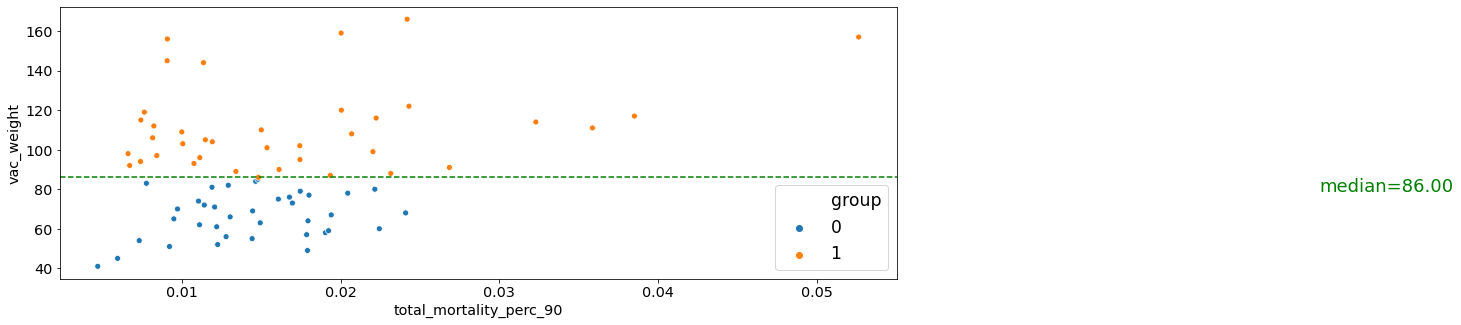

In [295]:
scatter_plot =sns.scatterplot(data=average_mortality, y='vac_weight', x='total_mortality_perc_90', hue='group')
scatter_plot.axhline(median_sgr, linestyle='--', color='green')
scatter_plot.text(df['total_mortality_perc_90'].max(), median_sgr, f"median={median_sgr:.2f}", color='green',fontsize=18, ha='right', va='top')
plt.show()


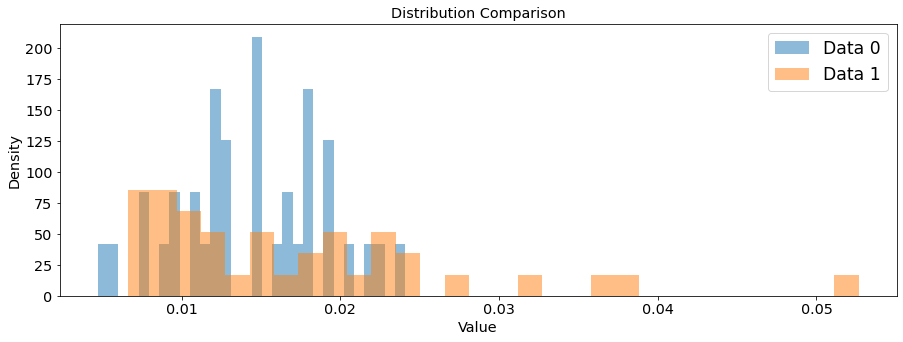

In [79]:
data0 = average_mortality[average_mortality['group'] == 0]['total_mortality_perc_90']
data1 = average_mortality[average_mortality['group'] == 1]['total_mortality_perc_90']
plt.hist(data0, bins=30, alpha=0.5, label='Data 0', density=True)
plt.hist(data1, bins=30, alpha=0.5, label='Data 1', density=True)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

In [80]:
num_samples=5000
sample_size=20
p_values=[]
u_stats=[]
for i in range(num_samples):
    sample0 = np.random.choice(data0, size=sample_size, replace=True)
    sample1 = np.random.choice(data1, size=sample_size, replace=True)
    statistic, p_value = mannwhitneyu(sample0, sample1, alternative='less')
    p_values.append(p_value)
    u_stats.append(statistic)
    #print("Mann-Whitney U statistic: ", statistic)
    #print("P-Value: ", p_value)

In [82]:
passed_count=0
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        passed_count=passed_count+1
print("Number of tests passed=",passed_count,"/",num_samples,"tests runned")

Number of tests passed= 466 / 5000 tests runned


In [83]:
u_stats_failed=[]
u_stats_passed=[]
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        u_stats_passed.append(u_stats[i])
    else:
        u_stats_failed.append(u_stats[i])

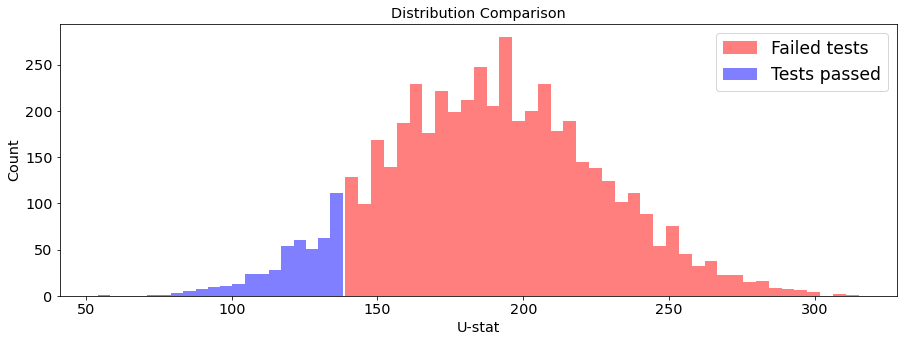

In [87]:
plt.hist(u_stats_failed, alpha=0.5, bins=40, label='Failed tests', density=False, color='red')
plt.hist(u_stats_passed, alpha=0.5, bins=20, label='Tests passed', density=False, color='blue')

plt.xlabel('U-stat')
plt.ylabel('Count')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

In [155]:
df_smolt_data = pd.read_csv('smolt_dataset.csv',delimiter=";")

df_smolt_data.insert(loc = 51, column = 'date_conf', value = np.nan)
df_smolt_data.reset_index(drop = True, inplace = True)
df_smolt_data ['transfer_date']= pd.to_datetime(df_smolt_data['transfer_date'])
df_smolt_data ['date_conf']= pd.to_datetime(df_smolt_data['date_conf'])                                                               
m = 0
while m < len(df_smolt_data):
    days_btw_transfer_conf = df_smolt_data.iloc[m] [50]
    print('days_btw_transfer_conf', days_btw_transfer_conf)
    if np.isnan(days_btw_transfer_conf) == True:
        df_smolt_data.iloc[m] [51] = np.nan
    else:    
        transfer_date = df_smolt_data.iloc[m] ['transfer_date']
        df_smolt_data.at[m, 'date_conf'] = transfer_date - dt.timedelta(days = int(days_btw_transfer_conf))
    m = m + 1
    
#df_smolt_data.to_csv(r'/Users/evgenijnotebook/Desktop/Salmon_project/data/smolt_dataset_wth_date_conf.csv', index = False)  

days_btw_transfer_conf nan
days_btw_transfer_conf 56.0
days_btw_transfer_conf 49.0
days_btw_transfer_conf nan
days_btw_transfer_conf 93.0
days_btw_transfer_conf nan
days_btw_transfer_conf 90.0
days_btw_transfer_conf 58.0
days_btw_transfer_conf 65.0
days_btw_transfer_conf 26.0
days_btw_transfer_conf 86.0
days_btw_transfer_conf 110.0
days_btw_transfer_conf 120.0
days_btw_transfer_conf 89.0
days_btw_transfer_conf 50.0
days_btw_transfer_conf nan
days_btw_transfer_conf 70.0
days_btw_transfer_conf 84.0
days_btw_transfer_conf 85.0
days_btw_transfer_conf 67.0
days_btw_transfer_conf 79.0
days_btw_transfer_conf 48.0
days_btw_transfer_conf 120.0
days_btw_transfer_conf 76.0
days_btw_transfer_conf nan
days_btw_transfer_conf 46.0
days_btw_transfer_conf 54.0
days_btw_transfer_conf 71.0
days_btw_transfer_conf 121.0
days_btw_transfer_conf 82.0
days_btw_transfer_conf 53.0
days_btw_transfer_conf 87.0
days_btw_transfer_conf 66.0
days_btw_transfer_conf 123.0
days_btw_transfer_conf 89.0
days_btw_transfer_co

days_btw_transfer_conf 49.0
days_btw_transfer_conf nan
days_btw_transfer_conf 70.0
days_btw_transfer_conf 70.0
days_btw_transfer_conf 95.0
days_btw_transfer_conf 107.0
days_btw_transfer_conf 94.0
days_btw_transfer_conf nan
days_btw_transfer_conf 110.0
days_btw_transfer_conf 83.0
days_btw_transfer_conf 54.0
days_btw_transfer_conf 49.0
days_btw_transfer_conf nan
days_btw_transfer_conf 51.0
days_btw_transfer_conf 57.0
days_btw_transfer_conf 26.0
days_btw_transfer_conf 74.0
days_btw_transfer_conf 70.0
days_btw_transfer_conf 48.0
days_btw_transfer_conf 48.0
days_btw_transfer_conf 123.0
days_btw_transfer_conf 83.0
days_btw_transfer_conf 52.0
days_btw_transfer_conf 76.0
days_btw_transfer_conf nan
days_btw_transfer_conf 77.0
days_btw_transfer_conf nan
days_btw_transfer_conf 82.0
days_btw_transfer_conf 85.0
days_btw_transfer_conf 48.0
days_btw_transfer_conf 83.0
days_btw_transfer_conf 105.0
days_btw_transfer_conf 67.0
days_btw_transfer_conf nan
days_btw_transfer_conf 58.0
days_btw_transfer_conf

days_btw_transfer_conf 110.0
days_btw_transfer_conf 127.0
days_btw_transfer_conf 117.0
days_btw_transfer_conf 121.0
days_btw_transfer_conf 117.0
days_btw_transfer_conf 119.0
days_btw_transfer_conf 55.0
days_btw_transfer_conf 84.0
days_btw_transfer_conf 56.0
days_btw_transfer_conf 56.0
days_btw_transfer_conf 66.0
days_btw_transfer_conf 83.0
days_btw_transfer_conf 73.0
days_btw_transfer_conf 63.0
days_btw_transfer_conf 83.0
days_btw_transfer_conf 74.0
days_btw_transfer_conf 75.0
days_btw_transfer_conf 53.0
days_btw_transfer_conf 66.0
days_btw_transfer_conf 53.0
days_btw_transfer_conf 64.0
days_btw_transfer_conf 73.0
days_btw_transfer_conf 83.0
days_btw_transfer_conf 74.0
days_btw_transfer_conf 74.0
days_btw_transfer_conf 77.0
days_btw_transfer_conf 66.0
days_btw_transfer_conf 64.0
days_btw_transfer_conf 73.0
days_btw_transfer_conf 75.0


In [156]:
len(df_smolt_data)

1091

In [157]:
df_smolt_data

,locus_id,fish_group_id,transfer_year,transfer_month,transfer_month_year,transfer_season,total_count,total_mortality_perc_90,transport_mortality_perc_90,nontransport_mortality_perc_90,...,date_conf,SGR,TGC,order_of_creation_from,strain,year_class,number_of_prod_cycle,place_first_feeding,specific_treatment,two_place_of_first_feeding
0,3046036,11,2017,1,1_2017,winter,"44934,175","0,007496165","0,001309054","0,006187111",...,NaT,NaN,NaN,6,FAN,16,C1,PH,None,0
1,3046036,1052,2019,1,1_2019,winter,"46388,23077","0,003942904","0,000924979","0,003017925",...,2018-11-20,"0,863440282","0,951440321",5,FLY,18,C1B,PH,None,0
2,3046036,3918,2020,11,11_2020,autumn,"45241,16667","0,007676062","0,005640632","0,002035429",...,2020-09-30,"0,972984604","1,181745984",11,FLY,19,C4,PH,LUF,0
3,3046043,310,2017,6,6_2017,summer,"38451,42593","0,018393697","0,006842934","0,011550763",...,NaT,NaN,NaN,10,FLY,16,C2B,PH,None,0
4,3046043,498,2019,7,7_2019,summer,"41131,79661","0,027013536","0,022782874","0,004230661",...,2019-04-24,"0,800972852","0,883692915",3,LCY,18,C3,PGR,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,7183889,6071,2022,6,6_2022,summer,"44747,76389","0,012812974","0,002758736","0,010054239",...,2022-04-08,"0,692506163","0,768343162",3,FLY,21,C2,PH,LUF,0
1087,7183890,6072,2022,6,6_2022,summer,"44563,77612","0,014813398","0,008025966","0,006787432",...,2022-07-02,"0,862384041","0,958244367",3,FLY,21,C2,PH,LUF,0
1088,7183891,6072,2022,6,6_2022,summer,"44585,79167","0,01465357","0,007419565","0,007234005",...,2022-07-04,"0,695116331","0,801179534",3,FLY,21,C2,PH,LUF,0
1089,7183892,6069,2022,6,6_2022,summer,"44244,95833","0,022575856","0,015284297","0,007291559",...,2022-03-25,"0,79240455","0,87628003",3,FLY,21,C2,PH,LUF,0


In [158]:
temperatures=pd.read_csv("FW_temperature_cleared.csv")

In [159]:
temperatures.columns

Index(['final_locus_population_id', 'event_date', 'temperature_cleared',
       'temperature', 'rolling_tempr'],
      dtype='object')

In [160]:
temperatures.head()

,final_locus_population_id,event_date,temperature_cleared,temperature,rolling_tempr
0,36783130,2017-09-01,15.900242,15.900242,15.900242
1,36783130,2017-09-02,15.900242,15.900242,15.900242
2,36783130,2017-09-03,15.600239,15.600239,15.600239
3,36783130,2017-09-04,15.800241,15.800241,15.800241
4,36783130,2017-09-05,15.833575,15.833575,15.833575


In [161]:
temperatures[temperatures.final_locus_population_id.isin([36794892])]

,final_locus_population_id,event_date,temperature_cleared,temperature,rolling_tempr
85608,36794892,2018-08-29,7.538574,7.538574,7.538574
85609,36794892,2018-08-30,8.000732,8.000732,8.000732
85610,36794892,2018-08-31,8.100742,8.100742,8.100742
85611,36794892,2018-09-01,8.700796,8.700796,8.700796
85612,36794892,2018-09-02,8.500778,8.500778,8.500778
...,...,...,...,...,...
85975,36794892,2019-08-31,13.000000,13.000000,12.926667
85976,36794892,2019-09-01,12.800000,12.800000,12.906667
85977,36794892,2019-09-02,12.200000,12.200000,12.883333
85978,36794892,2019-09-03,11.800000,11.800000,12.846667


In [162]:
from_locus_population_id

NameError: name 'from_locus_population_id' is not defined

In [163]:
df_smolt_data['transfer_date'] = pd.to_datetime(df_smolt_data['transfer_date'])
df_smolt_data['date_conf'] = pd.to_datetime(df_smolt_data['date_conf'])
temperatures['date'] = pd.to_datetime(temperatures['event_date'])

In [164]:
merged_df = df_smolt_data.merge(temperatures, left_on='from_locus_population_id', right_on='final_locus_population_id')


In [165]:
sums_by_id = {}


In [166]:
grouped_df = merged_df.groupby('from_locus_population_id')

In [167]:
for group_id, group_data in grouped_df:
    filtered_data = group_data[group_data.apply(lambda row: row['date'] <= row['transfer_date'] and row['date'] >= row['date_conf'], axis=1)]
    sum_of_tempr = filtered_data['rolling_tempr'].sum()
    sums_by_id[group_id] = sum_of_tempr

In [168]:
for group_id, sum_of_tempr in sums_by_id.items():
    print(f"Sum of 'rolling_tempr' for group {group_id}: {sum_of_tempr}")

Sum of 'rolling_tempr' for group 36783130: 3972.298327166667
Sum of 'rolling_tempr' for group 36783339: 3748.164120666667
Sum of 'rolling_tempr' for group 36783413: 278.68
Sum of 'rolling_tempr' for group 36783453: 252.37333333333333
Sum of 'rolling_tempr' for group 36783456: 0.0
Sum of 'rolling_tempr' for group 36783638: 882.8177266333333
Sum of 'rolling_tempr' for group 36783641: 0.0
Sum of 'rolling_tempr' for group 36783876: 0.0
Sum of 'rolling_tempr' for group 36783881: 0.0
Sum of 'rolling_tempr' for group 36783885: 764.0349508500001
Sum of 'rolling_tempr' for group 36783890: 3311.3559606
Sum of 'rolling_tempr' for group 36783892: 0.0
Sum of 'rolling_tempr' for group 36783897: 1002.4402015333332
Sum of 'rolling_tempr' for group 36783904: 865.0845924333335
Sum of 'rolling_tempr' for group 36783918: 0.0
Sum of 'rolling_tempr' for group 36783943: 2875.8156448000004
Sum of 'rolling_tempr' for group 36783984: 0.0
Sum of 'rolling_tempr' for group 36783987: 1130.6835373
Sum of 'rolling_te

In [169]:
df_smolt_data = df_smolt_data.merge(pd.DataFrame({'from_locus_population_id': list(sums_by_id.keys()), 'rolling_tempr_sum': list(sums_by_id.values())}), on='from_locus_population_id', how='left')

In [170]:
df_smolt_data

,locus_id,fish_group_id,transfer_year,transfer_month,transfer_month_year,transfer_season,total_count,total_mortality_perc_90,transport_mortality_perc_90,nontransport_mortality_perc_90,...,SGR,TGC,order_of_creation_from,strain,year_class,number_of_prod_cycle,place_first_feeding,specific_treatment,two_place_of_first_feeding,rolling_tempr_sum
0,3046036,11,2017,1,1_2017,winter,"44934,175","0,007496165","0,001309054","0,006187111",...,NaN,NaN,6,FAN,16,C1,PH,None,0,NaN
1,3046036,1052,2019,1,1_2019,winter,"46388,23077","0,003942904","0,000924979","0,003017925",...,"0,863440282","0,951440321",5,FLY,18,C1B,PH,None,0,783.761800
2,3046036,3918,2020,11,11_2020,autumn,"45241,16667","0,007676062","0,005640632","0,002035429",...,"0,972984604","1,181745984",11,FLY,19,C4,PH,LUF,0,641.489505
3,3046043,310,2017,6,6_2017,summer,"38451,42593","0,018393697","0,006842934","0,011550763",...,NaN,NaN,10,FLY,16,C2B,PH,None,0,NaN
4,3046043,498,2019,7,7_2019,summer,"41131,79661","0,027013536","0,022782874","0,004230661",...,"0,800972852","0,883692915",3,LCY,18,C3,PGR,None,1,2494.159925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,7183889,6071,2022,6,6_2022,summer,"44747,76389","0,012812974","0,002758736","0,010054239",...,"0,692506163","0,768343162",3,FLY,21,C2,PH,LUF,0,1073.508762
1087,7183890,6072,2022,6,6_2022,summer,"44563,77612","0,014813398","0,008025966","0,006787432",...,"0,862384041","0,958244367",3,FLY,21,C2,PH,LUF,0,0.000000
1088,7183891,6072,2022,6,6_2022,summer,"44585,79167","0,01465357","0,007419565","0,007234005",...,"0,695116331","0,801179534",3,FLY,21,C2,PH,LUF,0,0.000000
1089,7183892,6069,2022,6,6_2022,summer,"44244,95833","0,022575856","0,015284297","0,007291559",...,"0,79240455","0,87628003",3,FLY,21,C2,PH,LUF,0,1001.523942


In [171]:
zero_count = (df_smolt_data['rolling_tempr_sum'] == 0).sum()
nan_count = df_smolt_data['rolling_tempr_sum'].isna().sum()

print("Number of zeros: ", zero_count)
print("Number of NaN values: ", nan_count)

Number of zeros:  98
Number of NaN values:  275


In [172]:
df_smolt_data = df_smolt_data[df_smolt_data['rolling_tempr_sum'] != 0]
df_smolt_data = df_smolt_data.dropna(subset=['rolling_tempr_sum'])
df_smolt_data = df_smolt_data.reset_index(drop=True)

In [173]:
df_smolt_data

,locus_id,fish_group_id,transfer_year,transfer_month,transfer_month_year,transfer_season,total_count,total_mortality_perc_90,transport_mortality_perc_90,nontransport_mortality_perc_90,...,SGR,TGC,order_of_creation_from,strain,year_class,number_of_prod_cycle,place_first_feeding,specific_treatment,two_place_of_first_feeding,rolling_tempr_sum
0,3046036,1052,2019,1,1_2019,winter,"46388,23077","0,003942904","0,000924979","0,003017925",...,"0,863440282","0,951440321",5,FLY,18,C1B,PH,None,0,783.761800
1,3046036,3918,2020,11,11_2020,autumn,"45241,16667","0,007676062","0,005640632","0,002035429",...,"0,972984604","1,181745984",11,FLY,19,C4,PH,LUF,0,641.489505
2,3046043,498,2019,7,7_2019,summer,"41131,79661","0,027013536","0,022782874","0,004230661",...,"0,800972852","0,883692915",3,LCY,18,C3,PGR,None,1,2494.159925
3,3046052,847,2019,7,7_2019,summer,"41498,96364","0,018026932","0,01520579","0,002821141",...,"1,041554869","1,163037416",3,FLY,18,C3,PGR,None,1,1233.198278
4,3046064,159,2019,4,4_2019,spring,"74572,21053","0,011419796","0,002201648","0,009218148",...,"1,265268997","1,409250642",7,FLY,18,C2B,PH,None,0,813.066101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,7183882,6069,2022,6,6_2022,summer,"44712,52","0,009888684","0,004718095","0,005170589",...,"0,968481654","1,115425012",4,FLY,21,C3,PH,LUF,0,736.388975
714,7183884,6069,2022,6,6_2022,summer,"44261,21622","0,02236275","0,014216011","0,008146739",...,"0,79240455","0,87628003",3,FLY,21,C2,PH,LUF,0,1001.523942
715,7183889,6071,2022,6,6_2022,summer,"44747,76389","0,012812974","0,002758736","0,010054239",...,"0,692506163","0,768343162",3,FLY,21,C2,PH,LUF,0,1073.508762
716,7183892,6069,2022,6,6_2022,summer,"44244,95833","0,022575856","0,015284297","0,007291559",...,"0,79240455","0,87628003",3,FLY,21,C2,PH,LUF,0,1001.523942


In [174]:
#df_smolt_data.drop(['rolling_tempr_sum_x'], axis='columns', inplace=True)

In [175]:
len(df_smolt_data)

718

In [176]:
df_smolt_data.columns

Index(['locus_id', 'fish_group_id', 'transfer_year', 'transfer_month',
       'transfer_month_year', 'transfer_season', 'total_count',
       'total_mortality_perc_90', 'transport_mortality_perc_90',
       'nontransport_mortality_perc_90', 'from_date', 'from_site_name',
       'from_site_id', 'from_locus_id', 'from_locus_population_id',
       'from_fish_group_id', 'from_fish_group_name', 'from_generation',
       'from_year_class', 'from_count_stocking', 'from_avg_weight', 'to_date',
       'type_id', 'to_site_name', 'to_site_id', 'to_locus_id',
       'to_locus_population_id', 'to_fish_group_id', 'to_fish_group_name',
       'to_generation', 'to_year_class', 'to_count_stocking', 'to_avg_weight',
       'transfer_date', 'from_fish_group_count', 'days_btw_to_from',
       'days_btw_to_transfer', 'vac_fish_count', 'vac_weight',
       'days_btw_conf_event', '00000000000SRSv/Pha ', '000IPN+AAA+VVV+ISA/Pha',
       'IPN+SRS+VIB+ASA+ISA/FAV', 'IPN+SRS+VVV+AAA+ISA/Pha',
       'IPN+SRS+VVV

# SGR

In [177]:
df_smolt_data['SGR'] = df_smolt_data['SGR'].str.replace(',', '.')

df_smolt_data['SGR'] = df_smolt_data['SGR'].astype(float)

In [178]:
df_smolt_data['total_mortality_perc_90'] = df_smolt_data['total_mortality_perc_90'].str.replace(',', '.')

df_smolt_data['total_mortality_perc_90'] = df_smolt_data['total_mortality_perc_90'].astype(float)

In [179]:
correlation = df_smolt_data['SGR'].corr(df_smolt_data['total_mortality_perc_90'])

print("Correlation between SGR and total_mortality_perc_90:", correlation)

Correlation between SGR and total_mortality_perc_90: -0.07611045027548537


In [180]:
df_smolt_data = df_smolt_data.dropna(subset=['SGR'])

df_smolt_data = df_smolt_data.reset_index(drop=True)

In [181]:
median_sgr = df_smolt_data['SGR'].median()


df_smolt_data['group'] = np.where(df_smolt_data['SGR'] < median_sgr, 0, 1)

In [182]:
df_smolt_data

,locus_id,fish_group_id,transfer_year,transfer_month,transfer_month_year,transfer_season,total_count,total_mortality_perc_90,transport_mortality_perc_90,nontransport_mortality_perc_90,...,TGC,order_of_creation_from,strain,year_class,number_of_prod_cycle,place_first_feeding,specific_treatment,two_place_of_first_feeding,rolling_tempr_sum,group
0,3046036,1052,2019,1,1_2019,winter,"46388,23077",0.003943,"0,000924979","0,003017925",...,"0,951440321",5,FLY,18,C1B,PH,None,0,783.761800,0
1,3046036,3918,2020,11,11_2020,autumn,"45241,16667",0.007676,"0,005640632","0,002035429",...,"1,181745984",11,FLY,19,C4,PH,LUF,0,641.489505,1
2,3046043,498,2019,7,7_2019,summer,"41131,79661",0.027014,"0,022782874","0,004230661",...,"0,883692915",3,LCY,18,C3,PGR,None,1,2494.159925,0
3,3046052,847,2019,7,7_2019,summer,"41498,96364",0.018027,"0,01520579","0,002821141",...,"1,163037416",3,FLY,18,C3,PGR,None,1,1233.198278,1
4,3046064,159,2019,4,4_2019,spring,"74572,21053",0.011420,"0,002201648","0,009218148",...,"1,409250642",7,FLY,18,C2B,PH,None,0,813.066101,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,7183882,6069,2022,6,6_2022,summer,"44712,52",0.009889,"0,004718095","0,005170589",...,"1,115425012",4,FLY,21,C3,PH,LUF,0,736.388975,1
714,7183884,6069,2022,6,6_2022,summer,"44261,21622",0.022363,"0,014216011","0,008146739",...,"0,87628003",3,FLY,21,C2,PH,LUF,0,1001.523942,0
715,7183889,6071,2022,6,6_2022,summer,"44747,76389",0.012813,"0,002758736","0,010054239",...,"0,768343162",3,FLY,21,C2,PH,LUF,0,1073.508762,0
716,7183892,6069,2022,6,6_2022,summer,"44244,95833",0.022576,"0,015284297","0,007291559",...,"0,87628003",3,FLY,21,C2,PH,LUF,0,1001.523942,0


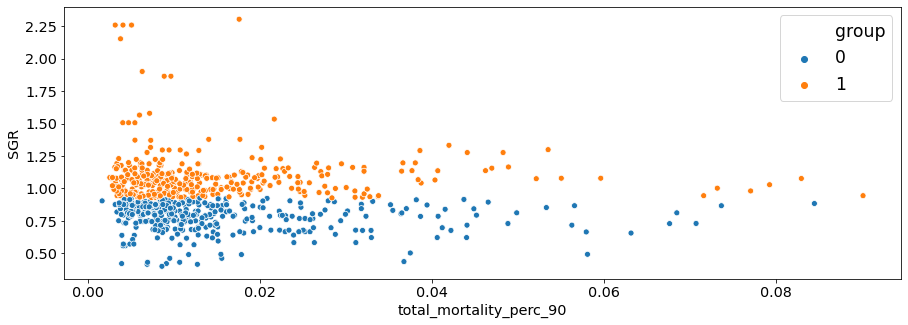

In [183]:
sns.scatterplot(data=df_smolt_data, x='total_mortality_perc_90', y='SGR', hue='group')
plt.show()


In [184]:
df_smolt_data['total_mortality_perc_90'] = pd.to_numeric(df_smolt_data['total_mortality_perc_90'], errors='coerce')


In [185]:
df_smolt_data

,locus_id,fish_group_id,transfer_year,transfer_month,transfer_month_year,transfer_season,total_count,total_mortality_perc_90,transport_mortality_perc_90,nontransport_mortality_perc_90,...,TGC,order_of_creation_from,strain,year_class,number_of_prod_cycle,place_first_feeding,specific_treatment,two_place_of_first_feeding,rolling_tempr_sum,group
0,3046036,1052,2019,1,1_2019,winter,"46388,23077",0.003943,"0,000924979","0,003017925",...,"0,951440321",5,FLY,18,C1B,PH,None,0,783.761800,0
1,3046036,3918,2020,11,11_2020,autumn,"45241,16667",0.007676,"0,005640632","0,002035429",...,"1,181745984",11,FLY,19,C4,PH,LUF,0,641.489505,1
2,3046043,498,2019,7,7_2019,summer,"41131,79661",0.027014,"0,022782874","0,004230661",...,"0,883692915",3,LCY,18,C3,PGR,None,1,2494.159925,0
3,3046052,847,2019,7,7_2019,summer,"41498,96364",0.018027,"0,01520579","0,002821141",...,"1,163037416",3,FLY,18,C3,PGR,None,1,1233.198278,1
4,3046064,159,2019,4,4_2019,spring,"74572,21053",0.011420,"0,002201648","0,009218148",...,"1,409250642",7,FLY,18,C2B,PH,None,0,813.066101,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,7183882,6069,2022,6,6_2022,summer,"44712,52",0.009889,"0,004718095","0,005170589",...,"1,115425012",4,FLY,21,C3,PH,LUF,0,736.388975,1
714,7183884,6069,2022,6,6_2022,summer,"44261,21622",0.022363,"0,014216011","0,008146739",...,"0,87628003",3,FLY,21,C2,PH,LUF,0,1001.523942,0
715,7183889,6071,2022,6,6_2022,summer,"44747,76389",0.012813,"0,002758736","0,010054239",...,"0,768343162",3,FLY,21,C2,PH,LUF,0,1073.508762,0
716,7183892,6069,2022,6,6_2022,summer,"44244,95833",0.022576,"0,015284297","0,007291559",...,"0,87628003",3,FLY,21,C2,PH,LUF,0,1001.523942,0


In [186]:
group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

sample_std = np.std(group_0, ddof=1) 

n = len(group_0)  
population_std = sample_std * np.sqrt(n / (n - 1))

In [187]:
sample_std


0.013306602967795473

In [188]:
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest

group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

population_std = 0.013306602967795473  

z_statistic, p_value = ztest(group_0, group_1, value=0, alternative='two-sided', usevar='pooled', ddof=0)

# Print the z-statistic and p-value
print("Z-Statistic: ", z_statistic)
print("P-Value: ", p_value)

Z-Statistic:  1.1383337679930507
P-Value:  0.2549811387330352


In [189]:
Z-test failed and non valid due to distribution form

SyntaxError: invalid syntax (<ipython-input-189-ec8b8be8399b>, line 1)

In [ ]:

group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']
group_0 = np.nan_to_num(group_0)
group_1 = np.nan_to_num(group_1)

#t_statistic, p_value = stats.ttest_ind(group_0, group_1)


#print("T-Statistic: ", t_statistic)
#print("P-Value: ", p_value)

In [ ]:
group_0

In [ ]:
group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

# Run t-test
t_statistic, p_value = stats.ttest_ind(group_0, group_1)

# Print the t-statistic and p-value
print("T-Statistic: ", t_statistic)
print("P-Value: ", p_value)

In [ ]:
T-test failed and non valid due to distribution form

In [ ]:
from scipy.stats import mannwhitneyu

group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

statistic, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')

print("Mann-Whitney U statistic: ", statistic)
print("P-Value: ", p_value)

In [190]:

mean_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].mean()
median_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].median()
#mode_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].agg(pd.Series.mode)
min_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].min()
max_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].max()
# Print the results
print("Mean values:")
print(mean_values)
print("\nMedian values:")
print(median_values)
#print("\nMode values:")
#print(mode_values)
print("\nMinimum values:")
print(min_values)
print("\nMaximum values:")
print(max_values)


Mean values:
group
0    0.015552
1    0.014418
Name: total_mortality_perc_90, dtype: float64

Median values:
group
0    0.010956
1    0.009621
Name: total_mortality_perc_90, dtype: float64

Minimum values:
group
0    0.001601
1    0.002496
Name: total_mortality_perc_90, dtype: float64

Maximum values:
group
0    0.084519
1    0.090181
Name: total_mortality_perc_90, dtype: float64


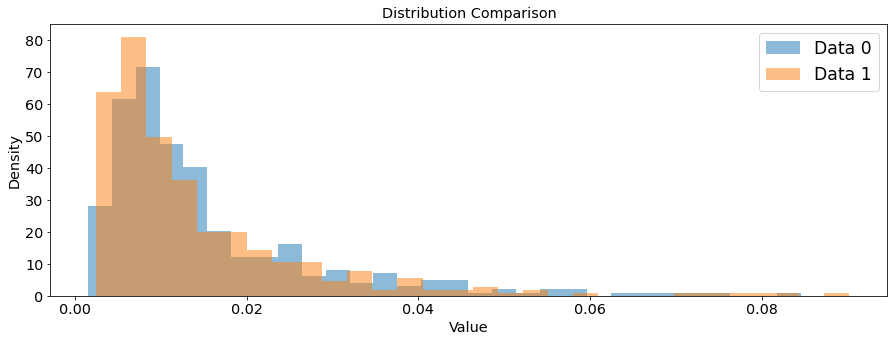

In [191]:
data0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
data1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']
plt.hist(data0, bins=30, alpha=0.5, label='Data 0', density=True)
plt.hist(data1, bins=30, alpha=0.5, label='Data 1', density=True)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

In [192]:
data0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']

In [193]:
sample_mean = data0.mean()
sample_std = data0.std()

In [194]:

sample_means0 = []
num_samples=3000
sample_size=30
for i in range(num_samples):
    sample = np.random.choice(data0, size=sample_size, replace=True)
    sample_means0.append(sample.mean())

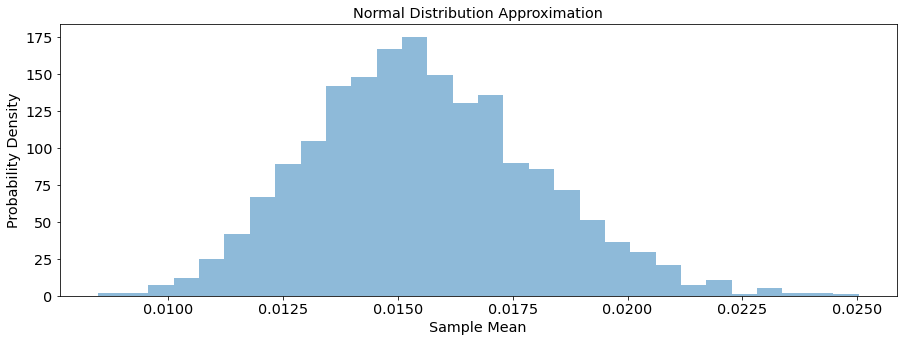

In [195]:

plt.hist(sample_means0, bins=30, density=True, alpha=0.5)
plt.xlabel('Sample Mean')
plt.ylabel('Probability Density')
plt.title('Normal Distribution Approximation')
plt.show()

In [196]:
sample_means

NameError: name 'sample_means' is not defined

In [197]:
data1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

In [198]:
sample_mean = data1.mean()
sample_std = data1.std()

In [199]:

sample_means1 = []
num_samples=3000
sample_size=30
for i in range(num_samples):
    sample = np.random.choice(data1, size=sample_size, replace=True)
    sample_means1.append(sample.mean())

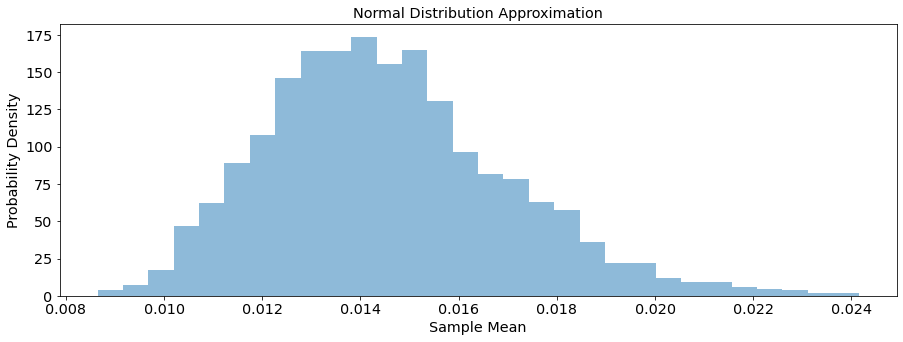

In [200]:

plt.hist(sample_means1, bins=30, density=True, alpha=0.5)
plt.xlabel('Sample Mean')
plt.ylabel('Probability Density')
plt.title('Normal Distribution Approximation')
plt.show()

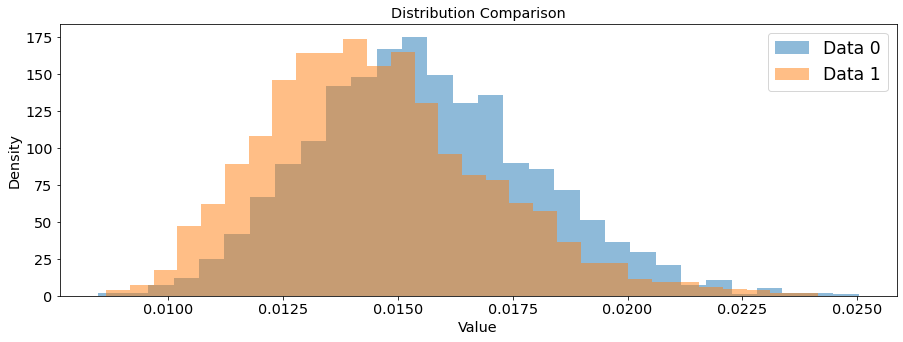

In [201]:
plt.hist(sample_means0, bins=30, alpha=0.5, label='Data 0', density=True)
plt.hist(sample_means1, bins=30, alpha=0.5, label='Data 1', density=True)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

In [202]:
data0


0      0.003943
2      0.027014
5      0.018263
7      0.010291
12     0.030168
         ...   
711    0.016086
714    0.022363
715    0.012813
716    0.022576
717    0.035174
Name: total_mortality_perc_90, Length: 359, dtype: float64

In [203]:
group_0 = sample_means0
group_1 = sample_means1

# Run t-test
t_statistic, p_value = stats.ttest_ind(group_0, group_1)

# Print the t-statistic and p-value
print("T-Statistic: ", t_statistic)
print("P-Value: ", p_value)

T-Statistic:  16.200579608213744
P-Value:  8.309125895569777e-58


# SGR filtered

In [551]:
sorted_df = df_smolt_data.sort_values('rolling_tempr_sum')
exclude_rows = int(len(sorted_df) * 0.25)
filtered_df = sorted_df.iloc[exclude_rows:-exclude_rows]
filtered_df = filtered_df.reset_index(drop=True)


In [552]:
df_smolt_data=filtered_df

In [553]:
df_smolt_data['SGR'] = df_smolt_data['SGR'].str.replace(',', '.')

df_smolt_data['SGR'] = df_smolt_data['SGR'].astype(float)

In [554]:
df_smolt_data['total_mortality_perc_90'] = df_smolt_data['total_mortality_perc_90'].str.replace(',', '.')

df_smolt_data['total_mortality_perc_90'] = df_smolt_data['total_mortality_perc_90'].astype(float)

In [555]:
correlation = df_smolt_data['SGR'].corr(df_smolt_data['total_mortality_perc_90'])

print("Correlation between SGR and total_mortality_perc_90:", correlation)

Correlation between SGR and total_mortality_perc_90: 0.020327075020659027


In [556]:
df_smolt_data = df_smolt_data.dropna(subset=['SGR'])

df_smolt_data = df_smolt_data.reset_index(drop=True)

In [557]:
median_sgr = df_smolt_data['SGR'].median()


df_smolt_data['group'] = np.where(df_smolt_data['SGR'] < median_sgr, 0, 1)

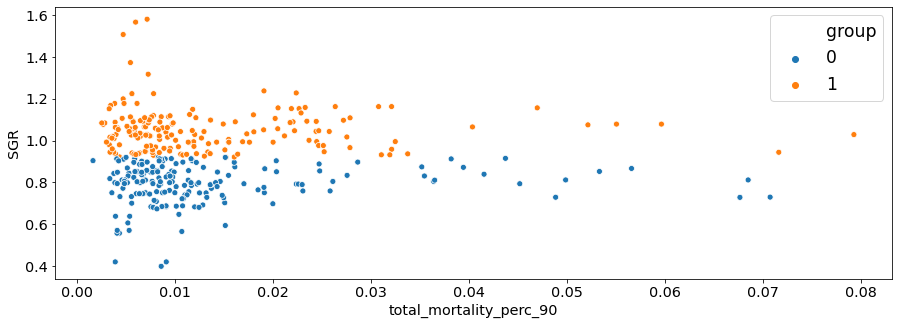

In [558]:
sns.scatterplot(data=df_smolt_data, x='total_mortality_perc_90', y='SGR', hue='group')
plt.show()


In [559]:

group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

statistic, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')

print("Mann-Whitney U statistic: ", statistic)
print("P-Value: ", p_value)

Mann-Whitney U statistic:  16241.0
P-Value:  0.9672781530968443


In [560]:

mean_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].mean()
median_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].median()
#mode_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].agg(pd.Series.mode)
min_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].min()
max_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].max()
# Print the results
print("Mean values:")
print(mean_values)
print("\nMedian values:")
print(median_values)
#print("\nMode values:")
#print(mode_values)
print("\nMinimum values:")
print(min_values)
print("\nMaximum values:")
print(max_values)

Mean values:
group
0    0.013445
1    0.013663
Name: total_mortality_perc_90, dtype: float64

Median values:
group
0    0.009200
1    0.009236
Name: total_mortality_perc_90, dtype: float64

Minimum values:
group
0    0.001601
1    0.002496
Name: total_mortality_perc_90, dtype: float64

Maximum values:
group
0    0.070746
1    0.079301
Name: total_mortality_perc_90, dtype: float64


# SGR + Sampling

In [37]:
from scipy.stats import mannwhitneyu

In [38]:
df_smolt_data['SGR'] = df_smolt_data['SGR'].str.replace(',', '.')

df_smolt_data['SGR'] = df_smolt_data['SGR'].astype(float)

In [219]:
df_smolt_data['total_mortality_perc_90'] = df_smolt_data['total_mortality_perc_90'].str.replace(',', '.')

df_smolt_data['total_mortality_perc_90'] = df_smolt_data['total_mortality_perc_90'].astype(float)
correlation = df_smolt_data['SGR'].corr(df_smolt_data['total_mortality_perc_90'])

print("Correlation between SGR and total_mortality_perc_90:", correlation)


AttributeError: Can only use .str accessor with string values!

In [234]:
df_smolt_data = df_smolt_data.dropna(subset=['SGR'])
df_smolt_data = df_smolt_data.reset_index(drop=True)
median_sgr = df_smolt_data['SGR'].median()
df_smolt_data['group'] = np.where(df_smolt_data['SGR'] < median_sgr, 0, 1)
df_smolt_data['total_mortality_perc_90'] = pd.to_numeric(df_smolt_data['total_mortality_perc_90'], errors='coerce')


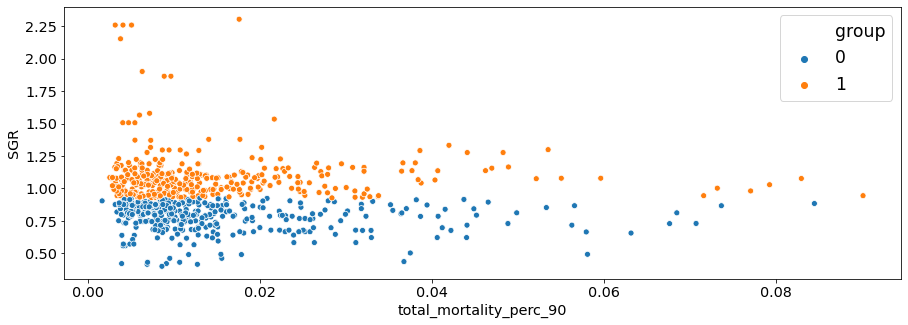

In [250]:
sns.scatterplot(data=df_smolt_data, x='total_mortality_perc_90', y='SGR', hue='group')
plt.show()

In [235]:
data1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']
data0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']

In [236]:
sample_mean = data1.mean()
sample_std = data1.std()

In [237]:
num_samples=5000
sample_size=20
p_values=[]
u_stats=[]
for i in range(num_samples):
    sample0 = np.random.choice(data0, size=sample_size, replace=True)
    sample1 = np.random.choice(data1, size=sample_size, replace=True)
    statistic, p_value = mannwhitneyu(sample0, sample1, alternative='less')
    p_values.append(p_value)
    u_stats.append(statistic)
    #print("Mann-Whitney U statistic: ", statistic)
    #print("P-Value: ", p_value)

(array([5.90405904e-05, 6.78966790e-04, 2.24354244e-03, 5.99261993e-03,
        9.69003690e-03, 1.01180812e-02, 5.67527675e-03, 2.08118081e-03,
        3.39483395e-04, 2.21402214e-05]),
 array([ 85. , 112.1, 139.2, 166.3, 193.4, 220.5, 247.6, 274.7, 301.8,
        328.9, 356. ]),
 <a list of 10 Patch objects>)

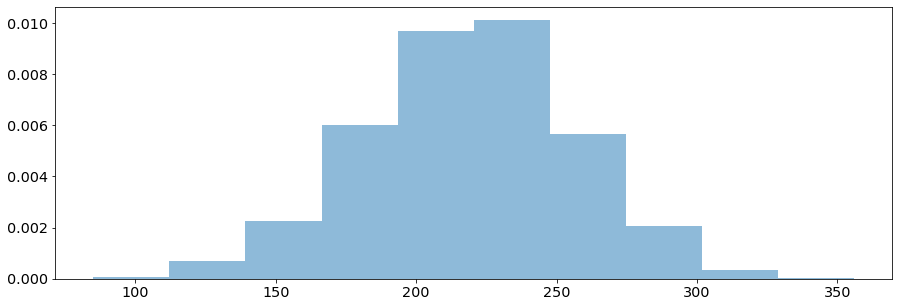

In [238]:
plt.hist(u_stats, alpha=0.5, density=True)

(array([2.21402214e-05, 8.85608856e-05, 6.64206642e-05, 3.32103321e-04,
        4.87084871e-04, 1.21771218e-03, 1.48339483e-03, 2.03690037e-03,
        3.21033210e-03, 4.29520295e-03, 5.62361624e-03, 8.05904059e-03,
        8.30258303e-03, 9.91881919e-03, 1.08487085e-02, 9.98523985e-03,
        1.09372694e-02, 9.43173432e-03, 6.99630996e-03, 5.64575646e-03,
        4.38376384e-03, 3.32103321e-03, 1.77121771e-03, 1.15129151e-03,
        6.42066421e-04, 2.21402214e-04, 1.54981550e-04, 2.21402214e-05,
        2.21402214e-05, 2.21402214e-05]),
 array([ 85.        ,  94.03333333, 103.06666667, 112.1       ,
        121.13333333, 130.16666667, 139.2       , 148.23333333,
        157.26666667, 166.3       , 175.33333333, 184.36666667,
        193.4       , 202.43333333, 211.46666667, 220.5       ,
        229.53333333, 238.56666667, 247.6       , 256.63333333,
        265.66666667, 274.7       , 283.73333333, 292.76666667,
        301.8       , 310.83333333, 319.86666667, 328.9       ,
      

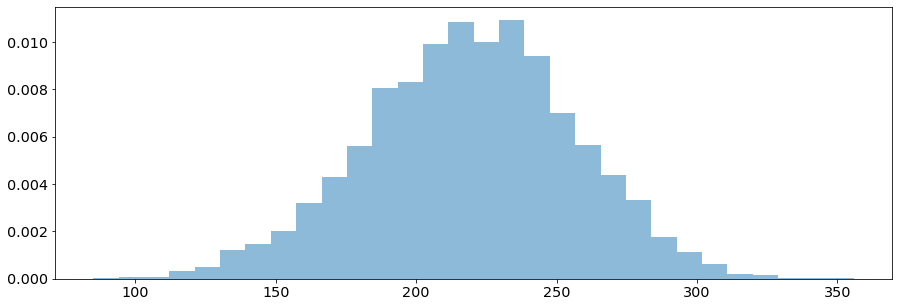

In [239]:
plt.hist(u_stats, bins=30, density=True, alpha=0.5)

(array([0.41040555, 0.47647084, 0.60860141, 0.66866075, 0.81480517,
        0.81880913, 1.08307026, 1.20118698, 1.62360441, 2.30427703]),
 array([9.76674137e-04, 1.00877857e-01, 2.00779039e-01, 3.00680221e-01,
        4.00581404e-01, 5.00482586e-01, 6.00383768e-01, 7.00284951e-01,
        8.00186133e-01, 9.00087315e-01, 9.99988498e-01]),
 <a list of 10 Patch objects>)

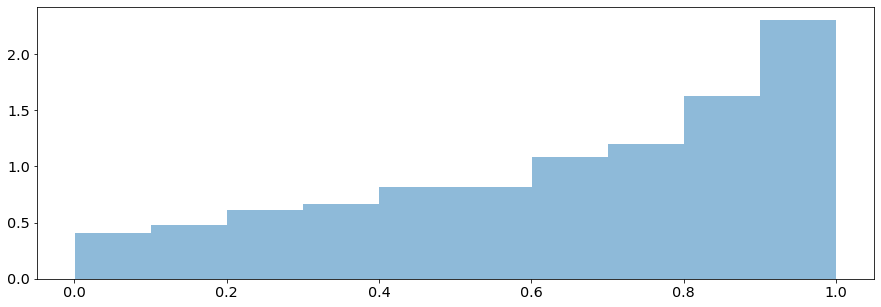

In [240]:
plt.hist(p_values, alpha=0.5, density=True)

In [241]:
#critical value for U-stats with sample size(20,20)=138
passed_count=0
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        passed_count=passed_count+1
print("Number of tests passed=",passed_count,"/",num_samples,"tests runned")

Number of tests passed= 91 / 5000 tests runned


In [242]:
#critical value for U-stats with sample size(20,20)=138
passed_count=0
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.1 and u_stats[i]<=138:
        passed_count=passed_count+1
print("Number of tests passed=",passed_count,"/",num_samples,"tests runned")

Number of tests passed= 91 / 5000 tests runned


In [243]:
u_stats_failed=[]
u_stats_passed=[]
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        u_stats_passed.append(u_stats[i])
    else:
        u_stats_failed.append(u_stats[i])
        
        


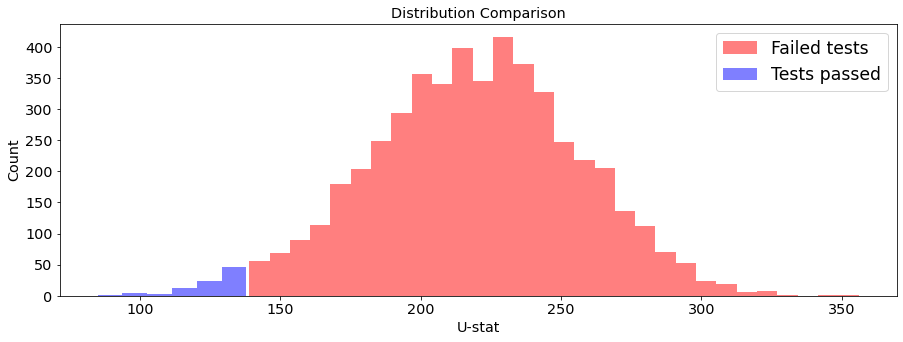

In [245]:
plt.hist(u_stats_failed, alpha=0.5, bins=30, label='Failed tests', density=False, color='red')
plt.hist(u_stats_passed, alpha=0.5, bins=6, label='Tests passed', density=False, color='blue')

plt.xlabel('U-stat')
plt.ylabel('Count')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

In [249]:
pd.DataFrame(u_stats).mean()

0    219.2154
dtype: float64

# TOP vs. AVG

In [128]:
df_smolt_data['SGR'] = df_smolt_data['SGR'].str.replace(',', '.')

df_smolt_data['SGR'] = df_smolt_data['SGR'].astype(float)

In [129]:
df_smolt_data['total_mortality_perc_90'] = df_smolt_data['total_mortality_perc_90'].str.replace(',', '.')

df_smolt_data['total_mortality_perc_90'] = df_smolt_data['total_mortality_perc_90'].astype(float)

In [130]:
df_smolt_data = df_smolt_data.dropna(subset=['SGR'])

df_smolt_data = df_smolt_data.reset_index(drop=True)

In [131]:
df_smolt_data['group'] = (df_smolt_data['SGR'].rank(ascending=False, method='first') <= 40).astype(int)

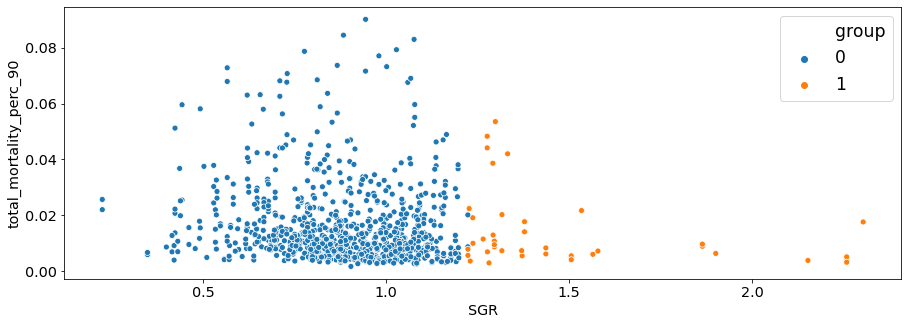

In [132]:
sns.scatterplot(data=df_smolt_data, y='total_mortality_perc_90', x='SGR', hue='group')
plt.show()

In [106]:
df_smolt_data['total_mortality_perc_90'] = pd.to_numeric(df_smolt_data['total_mortality_perc_90'], errors='coerce')


In [107]:

mean_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].mean()
median_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].median()
#mode_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].agg(pd.Series.mode)
min_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].min()
max_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].max()
# Print the results
print("Mean values:")
print(mean_values)
print("\nMedian values:")
print(median_values)
#print("\nMode values:")
#print(mode_values)
print("\nMinimum values:")
print(min_values)
print("\nMaximum values:")
print(max_values)

Mean values:
group
0    0.015036
1    0.014127
Name: total_mortality_perc_90, dtype: float64

Median values:
group
0    0.010545
1    0.008630
Name: total_mortality_perc_90, dtype: float64

Minimum values:
group
0    0.001601
1    0.003125
Name: total_mortality_perc_90, dtype: float64

Maximum values:
group
0    0.090181
1    0.053521
Name: total_mortality_perc_90, dtype: float64


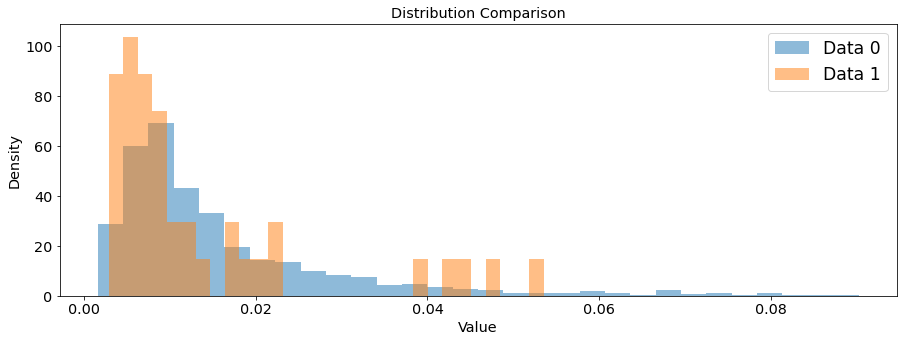

In [133]:
data0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
data1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']
plt.hist(data0, bins=30, alpha=0.5, label='Data 0', density=True)
plt.hist(data1, bins=30, alpha=0.5, label='Data 1', density=True)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

In [134]:
data1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']
data0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']

In [135]:
num_samples=5000
sample_size=20
p_values=[]
u_stats=[]
for i in range(num_samples):
    sample0 = np.random.choice(data0, size=sample_size, replace=True)
    sample1 = np.random.choice(data1, size=sample_size, replace=True)
    statistic, p_value = mannwhitneyu(sample0, sample1, alternative='two-sided')
    p_values.append(p_value)
    u_stats.append(statistic)
    #print("Mann-Whitney U statistic: ", statistic)
    #print("P-Value: ", p_value)

(array([2.38095238e-05, 4.76190476e-05, 1.42857143e-04, 3.33333333e-04,
        7.14285714e-04, 9.28571429e-04, 1.61904762e-03, 2.71428571e-03,
        3.16666667e-03, 4.69047619e-03, 6.47619048e-03, 7.73809524e-03,
        9.50000000e-03, 9.90476190e-03, 9.40476190e-03, 1.14285714e-02,
        9.57142857e-03, 9.88095238e-03, 7.76190476e-03, 6.83333333e-03,
        5.80952381e-03, 3.78571429e-03, 2.76190476e-03, 1.85714286e-03,
        1.02380952e-03, 5.23809524e-04, 1.90476190e-04, 1.19047619e-04,
        7.14285714e-05, 2.38095238e-05]),
 array([109. , 117.4, 125.8, 134.2, 142.6, 151. , 159.4, 167.8, 176.2,
        184.6, 193. , 201.4, 209.8, 218.2, 226.6, 235. , 243.4, 251.8,
        260.2, 268.6, 277. , 285.4, 293.8, 302.2, 310.6, 319. , 327.4,
        335.8, 344.2, 352.6, 361. ]),
 <a list of 30 Patch objects>)

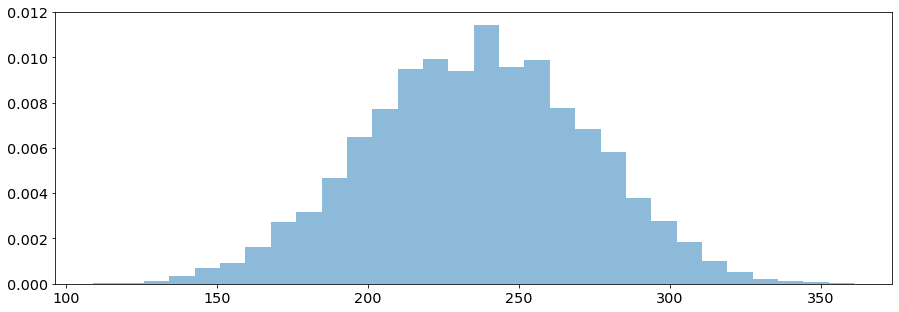

In [136]:
plt.hist(u_stats, bins=30, alpha=0.5, density=True)

In [137]:
#critical value for U-stats with sample size(20,20)=138
passed_count=0
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        passed_count=passed_count+1
print("Number of tests passed=",passed_count,"/",num_samples,"tests runned")

Number of tests passed= 4 / 5000 tests runned


In [140]:
u_stats_failed=[]
u_stats_passed=[]
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        u_stats_passed.append(u_stats[i])
    else:
        u_stats_failed.append(u_stats[i])
        
        


In [143]:
u_stats_passed

[119.0, 109.0, 125.0, 127.0]

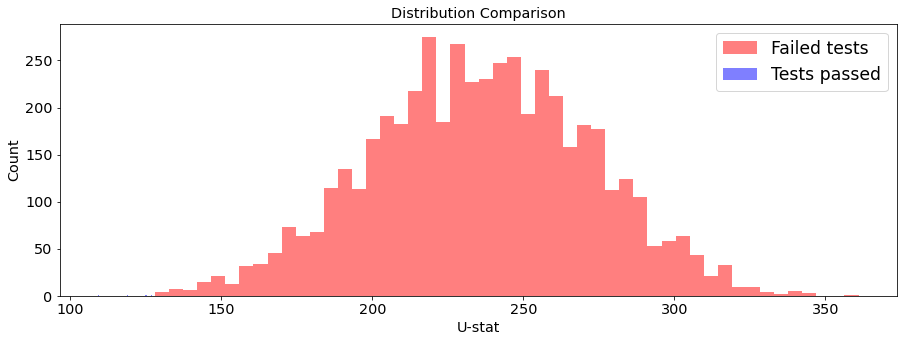

In [147]:
plt.hist(u_stats_failed, alpha=0.5, bins=50, label='Failed tests', density=False, color='red')
plt.hist(u_stats_passed, alpha=0.5, bins=50, label='Tests passed', density=False, color='blue')

plt.xlabel('U-stat')
plt.ylabel('Count')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

# TGC

In [335]:
df_smolt_data['TGC'] = df_smolt_data['TGC'].str.replace(',', '.')

df_smolt_data['TGC'] = df_smolt_data['TGC'].astype(float)

In [336]:
df_smolt_data = df_smolt_data.dropna(subset=['TGC'])

df_smolt_data = df_smolt_data.reset_index(drop=True)

In [337]:
median_tgc = df_smolt_data['TGC'].median()


df_smolt_data['group'] = np.where(df_smolt_data['TGC'] < median_tgc, 0, 1)

In [338]:
df_smolt_data

,locus_id,fish_group_id,transfer_year,transfer_month,transfer_month_year,transfer_season,total_count,total_mortality_perc_90,transport_mortality_perc_90,nontransport_mortality_perc_90,...,TGC,order_of_creation_from,strain,year_class,number_of_prod_cycle,place_first_feeding,specific_treatment,two_place_of_first_feeding,rolling_tempr_sum,group
0,3046036,1052,2019,1,1_2019,winter,"46388,23077",0.003943,"0,000924979","0,003017925",...,0.951440,5,FLY,18,C1B,PH,None,0,783.761800,0
1,3046036,3918,2020,11,11_2020,autumn,"45241,16667",0.007676,"0,005640632","0,002035429",...,1.181746,11,FLY,19,C4,PH,LUF,0,641.489505,1
2,3046043,498,2019,7,7_2019,summer,"41131,79661",0.027014,"0,022782874","0,004230661",...,0.883693,3,LCY,18,C3,PGR,None,1,2494.159925,0
3,3046052,847,2019,7,7_2019,summer,"41498,96364",0.018027,"0,01520579","0,002821141",...,1.163037,3,FLY,18,C3,PGR,None,1,1233.198278,1
4,3046064,159,2019,4,4_2019,spring,"74572,21053",0.011420,"0,002201648","0,009218148",...,1.409251,7,FLY,18,C2B,PH,None,0,813.066101,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,7183882,6069,2022,6,6_2022,summer,"44712,52",0.009889,"0,004718095","0,005170589",...,1.115425,4,FLY,21,C3,PH,LUF,0,736.388975,1
714,7183884,6069,2022,6,6_2022,summer,"44261,21622",0.022363,"0,014216011","0,008146739",...,0.876280,3,FLY,21,C2,PH,LUF,0,1001.523942,0
715,7183889,6071,2022,6,6_2022,summer,"44747,76389",0.012813,"0,002758736","0,010054239",...,0.768343,3,FLY,21,C2,PH,LUF,0,1073.508762,0
716,7183892,6069,2022,6,6_2022,summer,"44244,95833",0.022576,"0,015284297","0,007291559",...,0.876280,3,FLY,21,C2,PH,LUF,0,1001.523942,0


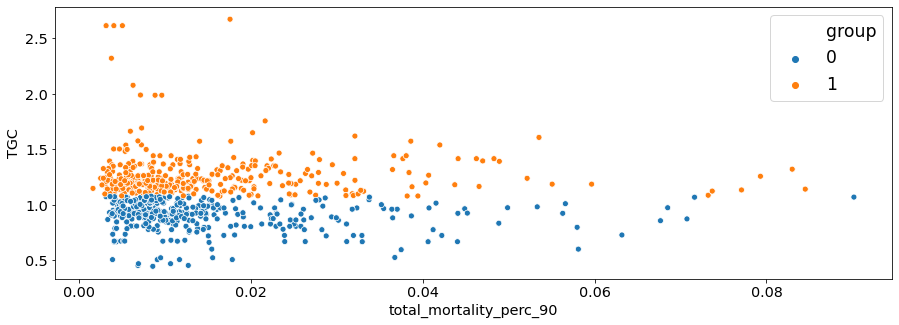

In [339]:
sns.scatterplot(data=df_smolt_data, x='total_mortality_perc_90', y='TGC', hue='group')
plt.show()


In [340]:
group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

sample_std = np.std(group_0, ddof=1) 

n = len(group_0)  
population_std = sample_std * np.sqrt(n / (n - 1))

In [341]:
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest

group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

population_std = sample_std 

z_statistic, p_value = ztest(group_0, group_1, value=0, alternative='two-sided', usevar='pooled', ddof=0)

# Print the z-statistic and p-value
print("Z-Statistic: ", z_statistic)
print("P-Value: ", p_value)

Z-Statistic:  0.15656234169421418
P-Value:  0.8755897834329559


In [342]:

group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']
group_0 = np.nan_to_num(group_0)
group_1 = np.nan_to_num(group_1)

In [343]:
group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

# Run t-test
t_statistic, p_value = stats.ttest_ind(group_0, group_1)

# Print the t-statistic and p-value
print("T-Statistic: ", t_statistic)
print("P-Value: ", p_value)

T-Statistic:  0.15634413623389776
P-Value:  0.8758058392390291


In [344]:
group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

statistic, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')

print("Mann-Whitney U statistic: ", statistic)
print("P-Value: ", p_value)

Mann-Whitney U statistic:  66794.0
P-Value:  0.3971361626745382


In [345]:

mean_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].mean()
median_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].median()
#mode_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].agg(pd.Series.mode)
min_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].min()
max_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].max()
# Print the results
print("Mean values:")
print(mean_values)
print("\nMedian values:")
print(median_values)
#print("\nMode values:")
#print(mode_values)
print("\nMinimum values:")
print(min_values)
print("\nMaximum values:")
print(max_values)


Mean values:
group
0    0.015063
1    0.014907
Name: total_mortality_perc_90, dtype: float64

Median values:
group
0    0.010629
1    0.010037
Name: total_mortality_perc_90, dtype: float64

Minimum values:
group
0    0.003121
1    0.001601
Name: total_mortality_perc_90, dtype: float64

Maximum values:
group
0    0.090181
1    0.084519
Name: total_mortality_perc_90, dtype: float64


In [66]:
df_smolt_data[df_smolt_data.from_locus_population_id.isin([36794095])]['date_conf']

798   2019-06-20
Name: date_conf, dtype: datetime64[ns]

In [47]:
df_smolt_data.columns

Index(['locus_id', 'fish_group_id', 'transfer_year', 'transfer_month',
       'transfer_month_year', 'transfer_season', 'total_count',
       'total_mortality_perc_90', 'transport_mortality_perc_90',
       'nontransport_mortality_perc_90', 'from_date', 'from_site_name',
       'from_site_id', 'from_locus_id', 'from_locus_population_id',
       'from_fish_group_id', 'from_fish_group_name', 'from_generation',
       'from_year_class', 'from_count_stocking', 'from_avg_weight', 'to_date',
       'type_id', 'to_site_name', 'to_site_id', 'to_locus_id',
       'to_locus_population_id', 'to_fish_group_id', 'to_fish_group_name',
       'to_generation', 'to_year_class', 'to_count_stocking', 'to_avg_weight',
       'transfer_date', 'from_fish_group_count', 'days_btw_to_from',
       'days_btw_to_transfer', 'vac_fish_count', 'vac_weight',
       'days_btw_conf_event', '00000000000SRSv/Pha ', '000IPN+AAA+VVV+ISA/Pha',
       'IPN+SRS+VIB+ASA+ISA/FAV', 'IPN+SRS+VVV+AAA+ISA/Pha',
       'IPN+SRS+VVV

In [49]:
temperatures['event_date'] = pd.to_datetime(temperatures['event_date'], format='%d.%m.%Y')

# Filter the dataframe based on the conditions
filtered_temperatures = temperatures[(temperatures['final_locus_population_id'] == 36794095) &
                                    (temperatures['event_date'] >= pd.to_datetime('27.09.2019', format='%d.%m.%Y')) &
                                    (temperatures['event_date'] <= pd.to_datetime('04.01.2020', format='%d.%m.%Y'))]

# Calculate the sum of rolling_tempr column in the filtered dataframe
sum_rolling_tempr = filtered_temperatures['rolling_tempr'].sum()


In [50]:
sum_rolling_tempr

12.496666666666668